In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:38943")
client

<Client: 'tcp://127.0.0.1:38943' processes=8 threads=32, memory=125.85 GiB>

In [2]:
import numpy as np
import xarray as xr
import pandas as pd
import os.path as op
import os
import xrft
import xwavelet
from scipy.interpolate import griddata
from scipy.stats import bootstrap
from xgcm.grid import Grid
from xmitgcm import open_mdsdataset
from fastjmd95 import rho as densjmd95
import matplotlib.colors as clr
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/tank/chaocean/qjamet/RUNS/ORAR/reruns2/'
gdir = '/tank/chaocean/grid_chaO/gridMIT_update1/'
savedir = '/tank/topog/tuchida/Wavelet-spectrum/'
tdgs = '/tank/tdgs/tuchida/TWA'
spec = '/tank/spectre/tuchida/NA-wavelets/'

In [4]:
grav = 9.81
nensembs = 5
Kh = 20.
K4 = 1e10
Kr = 1e-5
thetaMax = 1e20
rhoConst = 9.998e2
# Cp = 3.994e3
Cp = 3989.244953
# years = np.arange(2008,2013,dtype=int)
ySstart = -15
yNstart = 15
yend = 50
dnf = 2160
nfile = 73

In [5]:
years = np.arange(1967,1968,dtype=int)
ntimes = np.arange(1419120,1576800,dnf).reshape(len(years),nfile)
dd = 0  # 
yystart = 0
ntimes[yystart,:]

array([1419120, 1421280, 1423440, 1425600, 1427760, 1429920, 1432080,
       1434240, 1436400, 1438560, 1440720, 1442880, 1445040, 1447200,
       1449360, 1451520, 1453680, 1455840, 1458000, 1460160, 1462320,
       1464480, 1466640, 1468800, 1470960, 1473120, 1475280, 1477440,
       1479600, 1481760, 1483920, 1486080, 1488240, 1490400, 1492560,
       1494720, 1496880, 1499040, 1501200, 1503360, 1505520, 1507680,
       1509840, 1512000, 1514160, 1516320, 1518480, 1520640, 1522800,
       1524960, 1527120, 1529280, 1531440, 1533600, 1535760, 1537920,
       1540080, 1542240, 1544400, 1546560, 1548720, 1550880, 1553040,
       1555200, 1557360, 1559520, 1561680, 1563840, 1566000, 1568160,
       1570320, 1572480, 1574640])

In [6]:
xs = [295,318,
      297.5,316,
      300,315
     ]
ys = [37,43,
      30.5,30,
      24,22
     ]
reg = 0
sreg = ['A','B','C','D','E','F']

xo = 50e3
ntheta = 36

nmembs = np.arange(100,148)
xchunk = 200
ychunk = 200

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


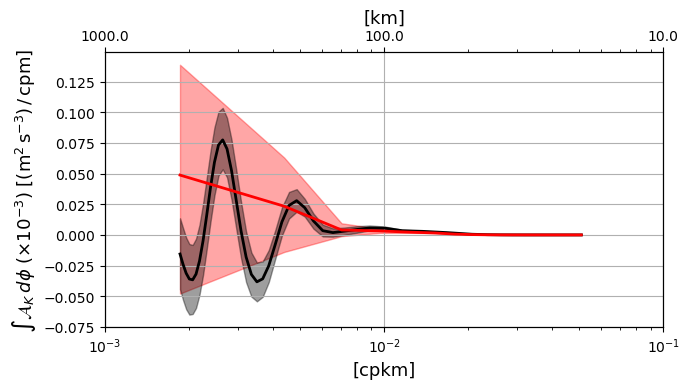

In [11]:
iZ = 1
iiter = 1419120

for reg in range(5,6):
    
    if reg == 0:
        ds0 = xr.open_dataset(op.join(savedir,'isoDiags_u_region%02d_1967-01-01.zarr' 
                                      % reg)
                             ).isel(Z=iZ)
        ds1 = xr.open_dataset(op.join(savedir,'isoDiags_v_region%02d_1967-01-01.zarr' 
                                      % reg)
                             ).isel(Z=iZ)
        ds4 = xr.open_dataset(op.join(spec,'Z0452/Points/%s/%010d/isoDiags-SP.zarr' 
                                      % (sreg[reg],iiter))
                             ).isel(Z=iZ)
    else:
        ds0 = xr.open_dataset(op.join(spec,'Points/%s/%010d/isoDiags_u.zarr' 
                                      % (sreg[reg],iiter))
                             ).isel(Z=iZ)
        ds1 = xr.open_dataset(op.join(spec,'Points/%s/%010d/isoDiags_v.zarr' 
                                      % (sreg[reg],iiter))
                             ).isel(Z=iZ)
        ds4 = xr.open_dataset(op.join(spec,'Points/%s/%010d/isoDiags-SP.zarr' 
                                      % (sreg[reg],iiter))
                             ).isel(Z=iZ)
    # ds4 = xr.open_dataset(op.join(savedir,
    #                               'isoDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' 
    #                               % reg))
    dtau = xr.open_zarr(op.join(spec,'Points/%s/%010d/isoDiags_u_tend-adv.zarr' 
                                % (sreg[reg],iiter))
                       ).isel(Z=iZ)
    dtav = xr.open_zarr(op.join(spec,'Points/%s/%010d/isoDiags_v_tend-adv.zarr' 
                                % (sreg[reg],iiter))
                       ).isel(Z=iZ)
    
    ns = 1
    
    for ny in range(-ns,ns+1):
        for nx in range(-ns,ns+1):
            if ny == 0 and nx == 0:
                pass
            # elif ny == -1 and nx == -1:
            #     pass
            else:
                if ny < 0:
                    if nx < 0:
                        # try:
                        ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_-%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_-%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        ds4  = xr.concat([ds4,xr.open_zarr(op.join(spec,
                                # savedir,
                                #         'isoDiags-MtE_region%02d_1967-01-01_-%02d-%02d.zarr' 
                                #                                % (reg,np.abs(ny),np.abs(nx))
                                    'Z0452/Points/%s/%010d/isoDiags-SP_-%02d-%02d.zarr' 
                                      % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                                )
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_-%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb')
                        dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_-%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb') 
                    else:
                        # try:
                        ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_-%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_-%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        ds4  = xr.concat([ds4,xr.open_zarr(op.join(spec,
                                # savedir,
                                #         'isoDiags-MtE_region%02d_1967-01-01_-%02d%02d.zarr' 
                                #                               % (reg,np.abs(ny),np.abs(nx))
                                    'Z0452/Points/%s/%010d/isoDiags-SP_-%02d%02d.zarr' 
                                      % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                            )
                                                              ).isel(Z=0)
                                             ], 'nmemb') 
                        dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_-%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb')
                        dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_-%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb') 
                else:
                    if nx < 0:
                        # try:
                        ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        ds4  = xr.concat([ds4,xr.open_zarr(op.join(spec,
                                # savedir,
                                #         'isoDiags-MtE_region%02d_1967-01-01_%02d-%02d.zarr' 
                                #                               % (reg,np.abs(ny),np.abs(nx))
                                    'Z0452/Points/%s/%010d/isoDiags-SP_%02d-%02d.zarr' 
                                      % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                            )
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb')
                        dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb') 
                    else:
                        # try:
                        ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb') 
                        ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb') 
                        ds4  = xr.concat([ds4,xr.open_zarr(op.join(spec,
                                # savedir,
                                #           'isoDiags-MtE_region%02d_1967-01-01_%02d%02d.zarr' 
                                #                                % (reg,np.abs(ny),np.abs(nx))
                                    'Z0452/Points/%s/%010d/isoDiags-SP_%02d%02d.zarr' 
                                      % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                                                                      )
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb') 
                        dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb') 


    dks = xr.DataArray(np.abs(np.diff(ds4.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(ds4.scale[1:].data + ds4.scale[:-1].data)}
                      ).interp(scale=ds4.scale, kwargs={"fill_value": "extrapolate"})
    # MtE = (ds4.iso_uA + ds4.iso_vA)
    SPu = ds4.iso_SPu
    SPv = ds4.iso_SPv
    SP = (SPu + SPv)
    Ak = (dtau.iso_uA + dtav.iso_vA
          # ds0.iso_uA + ds1.iso_vA
          # - MtE
          + SP
         )
    # MtE = -(ds4.upupUx + ds4.vpupUy + ds4.wpupUz
    #         + ds4.upvpVx + ds4.vpvpVy + ds4.wpvpVz
    #        )
    # Ak = (ds0.iso_uA + ds1.iso_vA
    #       # - (ds4.iso_uA + ds4.iso_vA)
    #       - MtE
    #      )
    piw = (Ak.sum('angle').compute() 
           * np.diff(ds0.angle)[0]*2)
    datas = (piw, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Pwres = bootstrap(datas, np.mean, confidence_level=0.95,
                      # n_resamples=100,
                      random_state=rng)
    
    if reg == 0:
        ds0f = xr.open_dataset(op.join(savedir,
                                       'crossFourierDiags_u_region%02d_1967-01-01.zarr' 
                                       % reg)).isel(Z=iZ)
        ds1f = xr.open_dataset(op.join(savedir,
                                       'crossFourierDiags_v_region%02d_1967-01-01.zarr' 
                                       % reg)).isel(Z=iZ)
        # ds4f = xr.open_dataset(op.join(savedir,
        #                                'crossFourierDiags-MtE_region%02d_1967-01-01.zarr' 
        #                                % reg))
        # ds4f = xr.open_dataset(op.join(savedir,
        #                         'crossFourierDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' 
        #                                % reg))
        ds4f = xr.open_dataset(op.join(spec,
                                       'Z0452/Points/%s/%010d/crossFourierDiags-SP.zarr' 
                                       % (sreg[reg],iiter)))
    else:
        ds0f = xr.open_dataset(op.join(spec,
                                       'Points/%s/%010d/crossFourierDiags_u.zarr' 
                                       % (sreg[reg],iiter))).isel(Z=iZ)
        ds1f = xr.open_dataset(op.join(spec,
                                       'Points/%s/%010d/crossFourierDiags_v.zarr' 
                                       % (sreg[reg],iiter))).isel(Z=iZ)
        # ds4f = xr.open_dataset(op.join(savedir,
        #                                'crossFourierDiags-MtE_region%02d_1967-01-01.zarr' 
        #                                % reg))
        # ds4f = xr.open_dataset(op.join(savedir,
        #                         'crossFourierDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' 
        #                                % reg))
        ds4f = xr.open_dataset(op.join(spec,
                                       'Points/%s/%010d/crossFourierDiags-SP.zarr' 
                                       % (sreg[reg],iiter)))
    dtauf = xr.open_zarr(op.join(spec,'Points/%s/%010d/crossFourierDiags_u_tend-adv.zarr' 
                                % (sreg[reg],iiter))
                        )
    dtavf = xr.open_zarr(op.join(spec,'Points/%s/%010d/crossFourierDiags_v_tend-adv.zarr' 
                                % (sreg[reg],iiter))
                        )
    
    SPu = ds4f.cs_SPu
    SPv = ds4f.cs_SPv
    SP = (SPu + SPv).isel(Z=iZ)
    Ak = ((dtauf.cs_uA + dtavf.cs_vA).isel(Z=iZ)
          # ds0f.cs_uA + ds1f.cs_vA
          # - MtE
          + SP
         )
    # MtE = -(ds4f.upupUx + ds4f.vpupUy + ds4f.wpupUz
    #         + ds4f.upvpVx + ds4f.vpvpVy + ds4f.wpvpVz
    #        )
    iso_cs = xrft.isotropize(
        # (ds0f.cs_uA + ds1f.cs_vA
        #                       # - (ds4f.MtEu + ds4f.MtEv)
        #                       - MtE
        #                      )
                             Ak.real, 
                             ["freq_YC","freq_XC"], truncate=True
            ).compute() * 2*np.pi
    pif = (iso_cs) 
    datas = (pif, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Pfres = bootstrap(datas, np.mean, confidence_level=0.95,
                      # n_resamples=100,
                      random_state=rng)
    # print(pif)
    
    fig, ax = plt.subplots(figsize=(7,4))
    fig.set_tight_layout(True)
    # ax2 = ax.twinx()
    ax3 = ax.twiny()
    
    ax.fill_between(iso_cs.freq_r*1e3, Pfres.confidence_interval.low*1e3, 
                    Pfres.confidence_interval.high*1e3, 
                    alpha=.35, color='r')
    ax.fill_between((ds0.scale)**-1*1e3, Pwres.confidence_interval.low*1e3, 
                    Pwres.confidence_interval.high*1e3, 
                    alpha=.38, color='k')
    
#             ax.plot(np.linspace(1e-3,5e-2,10), np.zeros(10), 'k', alpha=.6, lw=1)
    # ax.plot((ds0.scale)**-1*1e3, piw.isel(angle=0,Z=0).mean(['nmemb'])*1e8,
    #         'r', lw=2, label=r"Zonal")
    # ax.plot((ds0.scale)**-1*1e3, piw.isel(angle=len(piw.angle)//2,Z=0).mean(['nmemb'])*1e8,
    #         'c', lw=2, label=r"Meridional")
    # ax.plot((ds0.scale)**-1*1e3, piw.isel(Z=0).mean(['nmemb','angle'])*1e8,
    #         'k', lw=2, label=r"Isotropic")
    ax.plot((ds0.scale)**-1*1e3, piw.mean(['nmemb'])*1e3,
            'k', lw=2, label=r"Wavelet")
    ax.plot(iso_cs.freq_r*1e3, pif.mean(['nmemb'])*1e3,
            'r', lw=2, label=r"Fourier")
    
    ax.set_xscale('log')
#             ax.set_yscale('log')
    # ax2.set_xscale('log')
    ax3.set_xscale('log')
#             ax2.set_yscale('log')
    ax.set_xlim([1e-3,1e-1])
    # if reg < 5:
    #     ax.set_ylim([-np.abs(piw.isel(Z=0,scale=-1).mean(['nmemb','angle'])*1e8*.9),
    #                  np.abs(piw.isel(Z=0,scale=-1).mean(['nmemb','angle'])*1e8*.9)])
    #     # ax2.set_ylim([-np.abs(pif.isel(Z=0,freq_r=0)*1e8*.9),
    #     #               np.abs(pif.isel(Z=0,freq_r=0)*1e8*.9)])
    # else:
    #     ax.set_ylim([-np.abs(piw.isel(Z=0).mean(['nmemb','angle'])).max()*1e8*.9,
    #                  np.abs(piw.isel(Z=0).mean(['nmemb','angle'])).max()*1e8*.9])
    ax3.set_xlim([1e-3,1e-1])
    ax3.set_xticks([1e-3,1e-2,1e-1])
    ax3.set_xticklabels([1e3,1e2,1e1])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax3.set_xlabel(r"[km]", fontsize=13)
    # ax2.set_ylim([-.3,1])
    # ax2.spines['right'].set_color('b')
    # ax2.yaxis.label.set_color('b')
    # ax2.tick_params(axis='y', colors='b')
    # ax.set_ylabel(r"$\epsilon_K$ ($\times 10^{-8}$) [m$^2$ s$^{-3}$]", fontsize=13)
    ax.set_ylabel(
        r"$\int \mathcal{A}_K\,d\phi$ ($\times 10^{-3}$) [(m$^2\,$s$^{-3})\,/\,$cpm]", 
                  fontsize=13)
    # ax2.set_ylabel(r"$\hat{\epsilon}$ ($\times 10^{-8}$) [m$^2$ s$^{-3}$]", 
    #                fontsize=13, c='b')
    ax.grid(True)
    if reg == 0:
        # ax.legend(loc='lower left', fontsize=12)
        ax.legend(loc='upper right', fontsize=12)
    plt.savefig(op.join(spec,'Figs/WvsF_KE-spectrans_3x3_Region%02d_Z452.pdf' % reg))
    # plt.savefig(op.join(savedir,
    #                     'Figs/WvsF_KE-specflux_reenvisioned_Region%02d_Z452.pdf' 
    #                     % reg))
    plt.show()

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


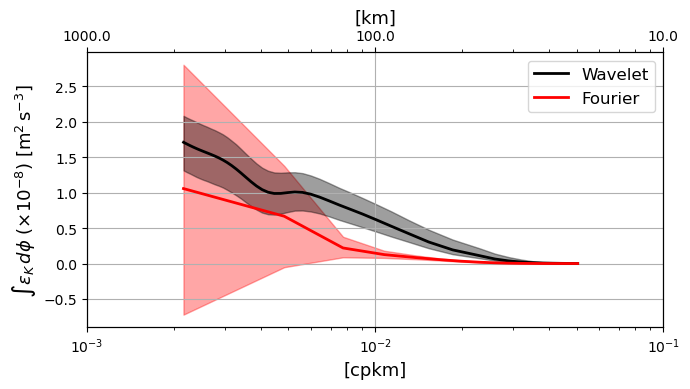

In [9]:
iZ = 1
# iiter = 1419120

for reg in range(1):
    if reg == 0:
        ds0 = xr.open_dataset(op.join(savedir,
                                      'isoDiags_u_region%02d_1967-01-01.zarr' 
                                      % reg)).isel(Z=iZ)
        ds1 = xr.open_dataset(op.join(savedir,
                                      'isoDiags_v_region%02d_1967-01-01.zarr' 
                                      % reg)).isel(Z=iZ)
        # ds4 = xr.open_dataset(op.join(savedir,
        #                               'isoDiags-MtE_region%02d_1967-01-01.zarr' 
        #                               % reg))
        # ds4 = xr.open_dataset(op.join(savedir,
        #                               'isoDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' 
        #                               % reg))
        ds4 = xr.open_dataset(op.join(spec,'Z0452/Points/%s/%010d/isoDiags-SP.zarr' 
                                      % (sreg[reg],iiter))
                             ).isel(Z=0)
    else:
        ds0 = xr.open_dataset(op.join(spec,
                                      'Points/%s/%010d/isoDiags_u.zarr' 
                                      % (sreg[reg],iiter))).isel(Z=iZ)
        ds1 = xr.open_dataset(op.join(spec,
                                      'Points/%s/%010d/isoDiags_v.zarr' 
                                      % (sreg[reg],iiter))).isel(Z=iZ)
        ds4 = xr.open_dataset(op.join(spec,'Points/%s/%010d/isoDiags-SP.zarr' 
                                      % (sreg[reg],iiter))
                             ).isel(Z=iZ)
    dtau = xr.open_zarr(op.join(spec,'Points/%s/%010d/isoDiags_u_tend-adv.zarr' 
                                % (sreg[reg],iiter))
                       ).isel(Z=iZ)
    dtav = xr.open_zarr(op.join(spec,'Points/%s/%010d/isoDiags_v_tend-adv.zarr' 
                                % (sreg[reg],iiter))
                       ).isel(Z=iZ)
    ns = 1
    
    for ny in range(-ns,ns+1):
        for nx in range(-ns,ns+1):
            if ny == 0 and nx == 0:
                pass
            # elif ny == -1 and nx == -1:
            #     pass
            else:
                if ny < 0:
                    if nx < 0:
                        # try:
                        ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_-%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_-%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        ds4  = xr.concat([ds4,xr.open_zarr(op.join(spec,
                                # savedir,
                                #         'isoDiags-MtE_region%02d_1967-01-01_-%02d-%02d.zarr' 
                                #                                % (reg,np.abs(ny),np.abs(nx))
                                        'Z0452/Points/%s/%010d/isoDiags-SP_-%02d-%02d.zarr' 
                                      % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                                )
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_-%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb')
                        dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_-%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb') 
                    else:
                        # try:
                        ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_-%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_-%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb') 
                        ds4  = xr.concat([ds4,xr.open_zarr(op.join(spec,
                                # savedir,
                                #         'isoDiags-MtE_region%02d_1967-01-01_-%02d%02d.zarr' 
                                #                               % (reg,np.abs(ny),np.abs(nx))
                                    'Z0452/Points/%s/%010d/isoDiags-SP_-%02d%02d.zarr' 
                                      % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                            )
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_-%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb')
                        dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_-%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb')
                else:
                    if nx < 0:
                        # try:
                        ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb') 
                        ds4  = xr.concat([ds4,xr.open_zarr(op.join(spec,
                                # savedir,
                                #         'isoDiags-MtE_region%02d_1967-01-01_%02d-%02d.zarr' 
                                #                               % (reg,np.abs(ny),np.abs(nx))
                                    'Z0452/Points/%s/%010d/isoDiags-SP_%02d-%02d.zarr' 
                                      % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                            )
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb')
                        dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb') 
                    else:
                        # try:
                        ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb') 
                        ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        ds4  = xr.concat([ds4,xr.open_zarr(op.join(spec,
                                # savedir,
                                #           'isoDiags-MtE_region%02d_1967-01-01_%02d%02d.zarr' 
                                #                                % (reg,np.abs(ny),np.abs(nx))
                                    'Z0452/Points/%s/%010d/isoDiags-SP_%02d%02d.zarr' 
                                      % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                                                                      )
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb') 
                        dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb')
                        
    dks = xr.DataArray(np.abs(np.diff(ds4.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(ds4.scale[1:].data + ds4.scale[:-1].data)}
                      ).interp(scale=ds4.scale, kwargs={"fill_value": "extrapolate"})
    # MtE = (ds4.iso_uA + ds4.iso_vA)
    SPu = ds4.iso_SPu
    SPv = ds4.iso_SPv
    SP = (SPu + SPv)
    Ak = (dtau.iso_uA + dtav.iso_vA
          # ds0.iso_uA + ds1.iso_vA
          # - MtE
          + SP
         )
    # MtE = -(ds4.upupUx + ds4.vpupUy + ds4.wpupUz
    #         + ds4.upvpVx + ds4.vpvpVy + ds4.wpvpVz
    #        )
    # Ak = (ds0.iso_uA + ds1.iso_vA
    #       # - (ds4.iso_uA + ds4.iso_vA)
    #       - MtE
    #      )
    piw = (((Ak) * dks).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
           * np.diff(ds0.angle)[0]*2)
    datas = (piw, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Pwres = bootstrap(datas, np.mean, confidence_level=0.95,
                      # n_resamples=100,
                      random_state=rng)
    
    if reg == 0:
        ds0f = xr.open_dataset(op.join(savedir,
                                       'crossFourierDiags_u_region%02d_1967-01-01.zarr' 
                                       % reg)).isel(Z=iZ)
        ds1f = xr.open_dataset(op.join(savedir,
                                       'crossFourierDiags_v_region%02d_1967-01-01.zarr' 
                                       % reg)).isel(Z=iZ)
        # ds4f = xr.open_dataset(op.join(savedir,
        #                                'crossFourierDiags-MtE_region%02d_1967-01-01.zarr' 
        #                                % reg))
        # ds4f = xr.open_dataset(op.join(savedir,
        #                         'crossFourierDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' 
        #                                % reg))
        ds4f = xr.open_dataset(op.join(spec,'Z0452/Points/%s/%010d/crossFourierDiags-SP.zarr' 
                                      % (sreg[reg],iiter)))
    else:
        ds0f = xr.open_dataset(op.join(spec,
                                       'Points/%s/%010d/crossFourierDiags_u.zarr' 
                                       % (sreg[reg],iiter))).isel(Z=iZ)
        ds1f = xr.open_dataset(op.join(spec,
                                       'Points/%s/%010d/crossFourierDiags_v.zarr' 
                                       % (sreg[reg],iiter))).isel(Z=iZ)
        ds4f = xr.open_dataset(op.join(spec,'Points/%s/%010d/crossFourierDiags-SP.zarr' 
                                      % (sreg[reg],iiter)))
    dtauf = xr.open_zarr(op.join(spec,'Points/%s/%010d/crossFourierDiags_u_tend-adv.zarr' 
                                % (sreg[reg],iiter))
                        )
    dtavf = xr.open_zarr(op.join(spec,'Points/%s/%010d/crossFourierDiags_v_tend-adv.zarr' 
                                % (sreg[reg],iiter))
                        )
        
    SPu = ds4f.cs_SPu
    SPv = ds4f.cs_SPv
    SP = (SPu + SPv).isel(Z=iZ)
    # MtE = (ds4f.MtEu + ds4f.MtEv)
    Ak = ((dtauf.cs_uA + dtavf.cs_vA).isel(Z=iZ)
          # ds0f.cs_uA + ds1f.cs_vA
          # - MtE
          + SP
         )
    # MtE = -(ds4f.upupUx + ds4f.vpupUy + ds4f.wpupUz
    #         + ds4f.upvpVx + ds4f.vpvpVy + ds4f.wpvpVz
    #        )
    iso_cs = xrft.isotropize(
        # (ds0f.cs_uA + ds1f.cs_vA
        #                       # - (ds4f.MtEu + ds4f.MtEv)
        #                       - MtE
        #                      )
                             Ak.real, 
                             ["freq_YC","freq_XC"], truncate=True
                    ).compute() * 2*np.pi
    pif = (iso_cs*np.abs(np.diff(iso_cs.freq_r)[0])
          )[...,::-1].cumsum('freq_r')[...,::-1].compute() 
    datas = (pif, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Pfres = bootstrap(datas, np.mean, confidence_level=0.95,
                      # n_resamples=100,
                      random_state=rng)
    # print(pif)
    
    
    fig, ax = plt.subplots(figsize=(7,4))
    fig.set_tight_layout(True)
    # ax2 = ax.twinx()
    ax3 = ax.twiny()
    
    ax.fill_between(iso_cs.freq_r*1e3, Pfres.confidence_interval.low*1e8, 
                    Pfres.confidence_interval.high*1e8, 
                    alpha=.35, color='r')
    ax.fill_between((ds0.scale)**-1*1e3, Pwres.confidence_interval.low*1e8, 
                    Pwres.confidence_interval.high*1e8, 
                    alpha=.38, color='k')
    
#             ax.plot(np.linspace(1e-3,5e-2,10), np.zeros(10), 'k', alpha=.6, lw=1)
    # ax.plot((ds0.scale)**-1*1e3, piw.isel(angle=0,Z=0).mean(['nmemb'])*1e8,
    #         'r', lw=2, label=r"Zonal")
    # ax.plot((ds0.scale)**-1*1e3, piw.isel(angle=len(piw.angle)//2,Z=0).mean(['nmemb'])*1e8,
    #         'c', lw=2, label=r"Meridional")
    # ax.plot((ds0.scale)**-1*1e3, piw.isel(Z=0).mean(['nmemb','angle'])*1e8,
    #         'k', lw=2, label=r"Isotropic")
    ax.plot((ds0.scale)**-1*1e3, piw.mean(['nmemb'])*1e8,
            'k', lw=2, label=r"Wavelet")
    ax.plot(iso_cs.freq_r*1e3, pif.mean(['nmemb'])*1e8,
            'r', lw=2, label=r"Fourier")
    
    ax.set_xscale('log')
#             ax.set_yscale('log')
    # ax2.set_xscale('log')
    ax3.set_xscale('log')
#             ax2.set_yscale('log')
    ax.set_xlim([1e-3,1e-1])
    # if reg < 5:
    #     ax.set_ylim([-np.abs(piw.isel(Z=0,scale=-1).mean(['nmemb','angle'])*1e8*.9),
    #                  np.abs(piw.isel(Z=0,scale=-1).mean(['nmemb','angle'])*1e8*.9)])
    #     # ax2.set_ylim([-np.abs(pif.isel(Z=0,freq_r=0)*1e8*.9),
    #     #               np.abs(pif.isel(Z=0,freq_r=0)*1e8*.9)])
    # else:
    #     ax.set_ylim([-np.abs(piw.isel(Z=0).mean(['nmemb','angle'])).max()*1e8*.9,
    #                  np.abs(piw.isel(Z=0).mean(['nmemb','angle'])).max()*1e8*.9])
    ax3.set_xlim([1e-3,1e-1])
    ax3.set_xticks([1e-3,1e-2,1e-1])
    ax3.set_xticklabels([1e3,1e2,1e1])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax3.set_xlabel(r"[km]", fontsize=13)
    # ax2.set_ylim([-.3,1])
    # ax2.spines['right'].set_color('b')
    # ax2.yaxis.label.set_color('b')
    # ax2.tick_params(axis='y', colors='b')
    # ax.set_ylabel(r"$\epsilon_K$ ($\times 10^{-8}$) [m$^2$ s$^{-3}$]", fontsize=13)
    ax.set_ylabel(r"$\int\epsilon_K\,d\phi$ ($\times 10^{-8}$) [m$^2\,$s$^{-3}$]", 
                  fontsize=13)
    # ax2.set_ylabel(r"$\hat{\epsilon}$ ($\times 10^{-8}$) [m$^2$ s$^{-3}$]", 
    #                fontsize=13, c='b')
    ax.grid(True)
    if reg == 0:
        # ax.legend(loc='lower left', fontsize=12)
        ax.legend(loc='upper right', fontsize=12)
    plt.savefig(op.join(spec,'Figs/WKE-specflux_3x3_Region%02d_Z452.pdf' % reg))
    # plt.savefig(op.join(savedir,
    #                     'Figs/WvsF_KE-specflux_reenvisioned_Region%02d_Z452.pdf' 
    #                     % reg))
    plt.show()

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails wh

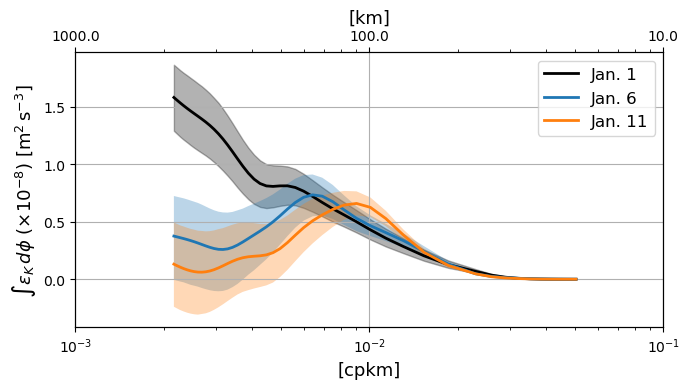

In [11]:
date = ['Jan. 1', 'Jan. 6', 'Jan. 11']
clrs = ['b', 'r']
iZ = 1

for reg in range(1):
    
    fig, ax = plt.subplots(figsize=(7,4))
    fig.set_tight_layout(True)
    # ax2 = ax.twinx()
    ax3 = ax.twiny()
    
    dd = 0
    for iiter in ntimes[0,:3]:
        
        if reg == 0:
            if iiter == ntimes[0,0]:
                ds0 = xr.open_dataset(op.join(savedir,'isoDiags_u_region%02d_1967-01-01.zarr' 
                                              % reg)
                                     ).isel(Z=iZ)
                ds1 = xr.open_dataset(op.join(savedir,'isoDiags_v_region%02d_1967-01-01.zarr' 
                                              % reg)
                                     ).isel(Z=iZ)
                ds4 = xr.open_dataset(op.join(spec,'Z0452/Points/%s/%010d/isoDiags-SP.zarr' 
                                              % (sreg[reg],iiter))
                                     ).isel(Z=iZ)
            else:
                ds0 = xr.open_dataset(op.join(savedir,
                                              'isoDiags_u_region%02d_%010d.zarr' 
                                              % (reg,iiter))).isel(Z=iZ)
                ds1 = xr.open_dataset(op.join(savedir,
                                              'isoDiags_v_region%02d_%010d.zarr' 
                                              % (reg,iiter))).isel(Z=iZ)
                ds4 = xr.open_dataset(op.join(spec,
                                              'Z0452/Points/%s/%010d/isoDiags-SP.zarr' 
                                              % (sreg[reg],iiter))
                                     ).isel(Z=iZ)
        else:
            ds0 = xr.open_dataset(op.join(spec,
                                          'Points/%s/%010d/isoDiags_u.zarr' 
                                          % (sreg[reg],iiter))).isel(Z=iZ)
            ds1 = xr.open_dataset(op.join(spec,
                                          'Points/%s/%010d/isoDiags_v.zarr' 
                                          % (sreg[reg],iiter))).isel(Z=iZ)
            ds4 = xr.open_dataset(op.join(spec,
                                          'Points/%s/%010d/isoDiags-SP.zarr' 
                                          % (sreg[reg],iiter))
                                 ).isel(Z=iZ)
        dtau = xr.open_zarr(op.join(spec,'Points/%s/%010d/isoDiags_u_tend-adv.zarr' 
                                    % (sreg[reg],iiter))
                           ).isel(Z=iZ)
        dtav = xr.open_zarr(op.join(spec,'Points/%s/%010d/isoDiags_v_tend-adv.zarr' 
                                    % (sreg[reg],iiter))
                           ).isel(Z=iZ)
        
        ns = 1
    
        for ny in range(-ns,ns+1):
            for nx in range(-ns,ns+1):
                if ny == 0 and nx == 0:
                    pass
                # elif ny == -1 and nx == -1:
                #     pass
                else:
                    if ny < 0:
                        if nx < 0:
                            # try:
                            ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_-%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                              np.abs(nx)))
                                                                  ).isel(Z=0)
                                                 ], 'nmemb')
                            ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_-%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                              np.abs(nx)))
                                                                  ).isel(Z=0)
                                                 ], 'nmemb')
                            ds4  = xr.concat([ds4,xr.open_zarr(
                                    op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags-SP_-%02d-%02d.zarr' 
                                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                                    )
                                                                  ).isel(Z=0)
                                                 ], 'nmemb')
                            dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_-%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                              ], 'nmemb')
                            dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_-%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                              ], 'nmemb') 
                        else:
                            # try:
                            ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_-%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                              np.abs(nx)))
                                                                  ).isel(Z=0)
                                                 ], 'nmemb')
                            ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_-%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                              np.abs(nx)))
                                                                  ).isel(Z=0)
                                                 ], 'nmemb') 
                            ds4  = xr.concat([ds4,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags-SP_-%02d%02d.zarr' 
                                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                                )
                                                                  ).isel(Z=0)
                                                 ], 'nmemb')
                            dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_-%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                              ], 'nmemb')
                            dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_-%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                              ], 'nmemb')
                    else:
                        if nx < 0:
                            # try:
                            ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                              np.abs(nx)))
                                                                  ).isel(Z=0)
                                                 ], 'nmemb')
                            ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                              np.abs(nx)))
                                                                  ).isel(Z=0)
                                                 ], 'nmemb') 
                            ds4  = xr.concat([ds4,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags-SP_%02d-%02d.zarr' 
                                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                                )
                                                                  ).isel(Z=0)
                                                 ], 'nmemb')
                            dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                              ], 'nmemb')
                            dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                              ], 'nmemb')
                        else:
                            # try:
                            ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                              np.abs(nx)))
                                                                  ).isel(Z=0)
                                                 ], 'nmemb') 
                            ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                              np.abs(nx)))
                                                                  ).isel(Z=0)
                                                 ], 'nmemb')
                            ds4  = xr.concat([ds4,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags-SP_%02d%02d.zarr' 
                                                  % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                                                                          )
                                                                  ).isel(Z=0)
                                                 ], 'nmemb')
                            dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                              ], 'nmemb') 
                            dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                              ], 'nmemb')

        
        dks = xr.DataArray(np.abs(np.diff(ds0.scale**-1)).data, dims='scale',
                           coords={'scale':.5*(ds0.scale[1:].data + ds0.scale[:-1].data)}
                          ).interp(scale=ds0.scale, kwargs={"fill_value": "extrapolate"})
        SPu = ds4.iso_SPu
        SPv = ds4.iso_SPv
        SP = (SPu + SPv)
        Ak = (dtau.iso_uA + dtav.iso_vA
              # ds0.iso_uA + ds1.iso_vA
              # - MtE
              + SP
             )
        piw = (((Ak) * dks).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
               * np.diff(ds0.angle)[0]*2).transpose('nmemb','scale')
        datas = (piw, )  # samples must be in a sequence
        rng = np.random.default_rng()
        Pwres = bootstrap(datas, np.mean, confidence_level=0.95,
                          # n_resamples=1000,
                          random_state=rng)
        if iiter == ntimes[0,0]:
            ax.fill_between((ds0.scale)**-1*1e3, Pwres.confidence_interval.low*1e8, 
                        Pwres.confidence_interval.high*1e8, 
                        color='k', 
                        alpha=.3)
        else:
            ax.fill_between((ds0.scale)**-1*1e3, Pwres.confidence_interval.low*1e8, 
                            Pwres.confidence_interval.high*1e8, 
                            # color=clrs[dd], 
                            alpha=.3)
        
        if iiter == ntimes[0,0]:
            ax.plot((ds0.scale)**-1*1e3, piw.mean(['nmemb'])*1e8,
                    c='k', 
                    lw=2, label=date[dd])
        else:
            ax.plot((ds0.scale)**-1*1e3, piw.mean(['nmemb'])*1e8,
                    # c=clrs[dd], 
                    lw=2, label=date[dd])
        dd += 1
        
    ax.set_xscale('log')
#             ax.set_yscale('log')
    ax3.set_xscale('log')
#             ax2.set_yscale('log')
    ax.set_xlim([1e-3,1e-1])
    # ax.set_ylim([-5e-3,None])
    ax3.set_xlim([1e-3,1e-1])
    ax3.set_xticks([1e-3,1e-2,1e-1])
    ax3.set_xticklabels([1e3,1e2,1e1])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax3.set_xlabel(r"[km]", fontsize=13)
    ax.set_ylabel(r"$\int\epsilon_K\,d\phi$ ($\times 10^{-8}$) [m$^2\,$s$^{-3}$]", 
                  fontsize=13)
#             ax2.set_ylabel(r"(Z=-1137) [m$^{-2}$ s$^{-3}$]", fontsize=13)
    ax.grid(True)
#             align_yaxis(ax, 0, ax2, 0)
    # if reg == 0:
    ax.legend(loc='upper right', fontsize=12)
#                 ax2.legend(loc='upper right', fontsize=12)
    plt.savefig(op.join(spec,
                        'Figs/WKE-specflux_3x3_Region%02d_Z452_temporal.pdf' 
                        % reg))
    # plt.savefig(op.join(savedir,
    #                     'Figs/WvsF-Ens-specflux_reenvisioned_Region%02d_Z452.pdf'
    #                     % reg))
    plt.show()

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


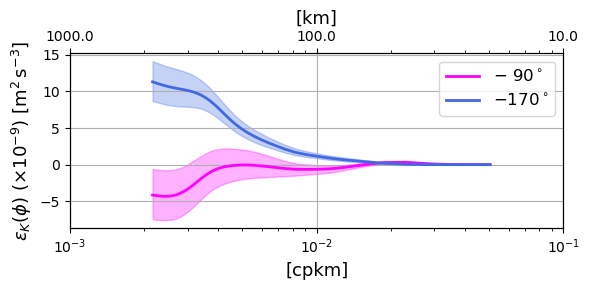

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


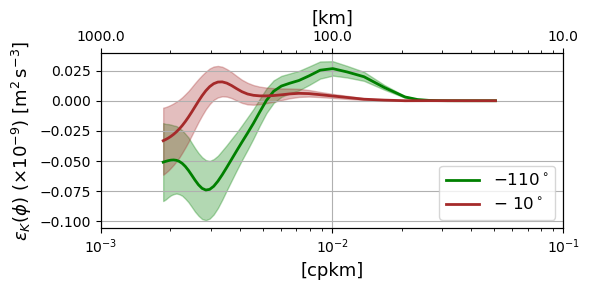

In [16]:
iZ = 1
amps = [.1,.03,.01,.002,.001,.001]
iiter = 1419120

# for reg in range(len(xs)):
for reg in np.array([0,5]):
    
    dsw = xr.open_zarr(
        '/tank/topog/tuchida/Wavelet-spectrum/isoDiags_KE_region%02d_1967-01-01.zarr'
                       % reg)
    iso_psUw = dsw.U
    iso_psVw = dsw.V
    dks = xr.DataArray(np.abs(np.diff(dsw.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(dsw.scale[1:].data + dsw.scale[:-1].data)}
                      ).interp(scale=dsw.scale, kwargs={"fill_value":"extrapolate"})
    E = .5*((iso_psUw + iso_psVw) * dks).sum('scale').mean('nmemb')
    iM = np.argmax(E.data)
    im = np.argmin(E.data)
    
    angles = np.linspace(0,180,18,endpoint=False)
    colors = ['k','brown','pink','lime','purple','gold',
              'olive','b','orange','magenta','r','g',
              'violet','cyan','aquamarine','peru','indianred','royalblue'
             ]
    if reg == 0:
        ds0 = xr.open_dataset(op.join(savedir,
                                      'isoDiags_u_region%02d_1967-01-01.zarr' 
                                      % reg)).isel(Z=iZ)
        ds1 = xr.open_dataset(op.join(savedir,
                                      'isoDiags_v_region%02d_1967-01-01.zarr' 
                                      % reg)).isel(Z=iZ)
    else:
        ds0 = xr.open_dataset(op.join(savedir,
                                      'isoDiags_u_region%02d_%010d.zarr' 
                                      % (reg,iiter))).isel(Z=iZ)
        ds1 = xr.open_dataset(op.join(savedir,
                                      'isoDiags_v_region%02d_%010d.zarr' 
                                      % (reg,iiter))).isel(Z=iZ)
    # ds4 = xr.open_dataset(op.join(savedir,'isoDiags-MtE_region%02d_1967-01-01.zarr' 
    #                               % reg))
    # ds4 = xr.open_dataset(op.join(savedir,
    #                               'isoDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' 
    #                               % reg))
    ds4 = xr.open_dataset(op.join(spec,'Z0452/Points/%s/%010d/isoDiags-SP.zarr' 
                                  % (sreg[reg],iiter))
                         ).isel(Z=iZ)
    dtau = xr.open_zarr(op.join(spec,'Points/%s/%010d/isoDiags_u_tend-adv.zarr' 
                                % (sreg[reg],iiter))
                        ).isel(Z=iZ)
    dtav = xr.open_zarr(op.join(spec,'Points/%s/%010d/isoDiags_v_tend-adv.zarr' 
                                % (sreg[reg],iiter))
                       ).isel(Z=iZ)
    ns = 1
    
    for ny in range(-ns,ns+1):
        for nx in range(-ns,ns+1):
            if ny == 0 and nx == 0:
                pass
            # elif ny == -1 and nx == -1:
            #     pass
            else:
                if ny < 0:
                    if nx < 0:
                        # try:
                        ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_-%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_-%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        ds4  = xr.concat([ds4,xr.open_zarr(op.join(spec,
                                # savedir,
                                #         'isoDiags-MtE_region%02d_1967-01-01_-%02d-%02d.zarr' 
                                #                                % (reg,np.abs(ny),np.abs(nx))
                                        'Z0452/Points/%s/%010d/isoDiags-SP_-%02d-%02d.zarr' 
                                      % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                                )
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_-%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb')
                        dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_-%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb') 
                    else:
                        # try:
                        ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_-%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_-%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb') 
                        ds4  = xr.concat([ds4,xr.open_zarr(op.join(spec,
                                # savedir,
                                #         'isoDiags-MtE_region%02d_1967-01-01_-%02d%02d.zarr' 
                                #                               % (reg,np.abs(ny),np.abs(nx))
                                    'Z0452/Points/%s/%010d/isoDiags-SP_-%02d%02d.zarr' 
                                      % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                            )
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_-%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb')
                        dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_-%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb')
                else:
                    if nx < 0:
                        # try:
                        ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb') 
                        ds4  = xr.concat([ds4,xr.open_zarr(op.join(spec,
                                # savedir,
                                #         'isoDiags-MtE_region%02d_1967-01-01_%02d-%02d.zarr' 
                                #                               % (reg,np.abs(ny),np.abs(nx))
                                    'Z0452/Points/%s/%010d/isoDiags-SP_%02d-%02d.zarr' 
                                      % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                            )
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb')
                        dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_%02d-%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb') 
                    else:
                        # try:
                        ds0  = xr.concat([ds0,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u_%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb') 
                        ds1  = xr.concat([ds1,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_v_%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                          np.abs(nx)))
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        ds4  = xr.concat([ds4,xr.open_zarr(op.join(spec,
                                # savedir,
                                #           'isoDiags-MtE_region%02d_1967-01-01_%02d%02d.zarr' 
                                #                                % (reg,np.abs(ny),np.abs(nx))
                                    'Z0452/Points/%s/%010d/isoDiags-SP_%02d%02d.zarr' 
                                      % (sreg[reg],iiter,np.abs(ny),np.abs(nx))
                                                                      )
                                                              ).isel(Z=0)
                                             ], 'nmemb')
                        dtau  = xr.concat([dtau,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_u_tend-adv_%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb') 
                        dtav  = xr.concat([dtav,xr.open_zarr(op.join(spec,
                                        'Z0452/Points/%s/%010d/isoDiags_v_tend-adv_%02d%02d.zarr' 
                                                                   % (sreg[reg],iiter,np.abs(ny),
                                                                      np.abs(nx)))
                                                          ).isel(Z=0)
                                          ], 'nmemb')
                        
    dks = xr.DataArray(np.abs(np.diff(ds4.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(ds4.scale[1:].data + ds4.scale[:-1].data)}
                      ).interp(scale=ds4.scale, kwargs={"fill_value": "extrapolate"})
    # MtE = (ds4.iso_uA + ds4.iso_vA)
    SPu = ds4.iso_SPu
    SPv = ds4.iso_SPv
    SP = (SPu + SPv)
    Ak = (dtau.iso_uA + dtav.iso_vA
          # ds0.iso_uA + ds1.iso_vA
          # - MtE
          + SP
         )
    
    fig, ax1 = plt.subplots(figsize=(6,3))
    fig.set_tight_layout(True)
    ax2 = ax1.twiny()
    
    for ag in np.array([iM,im]):
        
        piw = (((Ak) * dks).isel(angle=ag)[...,::-1].cumsum('scale')[...,::-1].compute() 
               *2).transpose('nmemb','scale')
        datas = (piw, )  # samples must be in a sequence
        rng = np.random.default_rng()
        Pwres = bootstrap(datas, np.mean, confidence_level=0.95,
                          random_state=rng)
        ax1.fill_between((ds0.scale)**-1*1e3, Pwres.confidence_interval.low*1e9, 
                        Pwres.confidence_interval.high*1e9, 
                        alpha=.3, color=colors[ag])

        ax1.plot((ds0.scale)**-1*1e3, piw.mean(['nmemb'])*1e9,
                # c=clrs[dd], 
                lw=2, c=colors[ag], label=r"$-$%3d$^\circ$" % angles[ag])
            

    ax1.set_xscale('log')
    # ax1.set_yscale('log')
    ax2.set_xscale('log')
    # ax2.set_yscale('log')
    ax1.set_xlim([1e-3,1e-1])
    ax2.set_xlim([1e-3,1e-1])
    ax2.set_xticks([1e-3,1e-2,1e-1])
    ax2.set_xticklabels([1e3,1e2,1e1])
    ax1.set_xlabel(r"[cpkm]", fontsize=13)
    ax2.set_xlabel(r"[km]", fontsize=13)
    ax1.set_ylabel(r"$\epsilon_K(\phi)\ (\times 10^{-9})$ [m$^2\,$s$^{-3}$]", fontsize=13)
    if reg > 0:
        ax1.legend(loc='lower right', fontsize=12)
    else:
        ax1.legend(loc='upper right', fontsize=12)
    ax1.grid(True)
    plt.savefig(op.join(spec,
        'Figs/Wavelet-EKE-specFlux_3x3_Region%02d_angles_Z452.pdf' 
                        % reg)
               )
    plt.show()
    plt.close()

In [8]:
reg = 0
ds0 = xr.open_dataset(op.join(savedir,'isoDiags_u_region%02d_1967-01-01.zarr' % reg))
ds1 = xr.open_dataset(op.join(savedir,'isoDiags_v_region%02d_1967-01-01.zarr' % reg))
ds4 = xr.open_dataset(op.join(savedir,'isoDiags-MtE_region%02d_1967-01-01.zarr' % reg))
# ds4 = xr.open_dataset(op.join(savedir,'isoDiags-MtE_reenvisioned_region%02d_1967-01-01.zarr' % reg))
dks = xr.DataArray(np.abs(np.diff(ds4.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(ds4.scale[1:].data + ds4.scale[:-1].data)}
                      ).interp(scale=ds4.scale, kwargs={"fill_value": "extrapolate"})
# MtE = -(ds4.upupUx + ds4.vpupUy + ds4.wpupUz
#         + ds4.upvpVx + ds4.vpvpVy + ds4.wpvpVz
#        )
# Ak = (ds0.iso_uA + ds1.iso_vA
#           # - (ds4.iso_uA + ds4.iso_vA)
#       - MtE
#      )
MtE = (ds4.iso_uA + ds4.iso_vA)
    
Ak = (ds0.iso_uA + ds1.iso_vA
      - MtE
     )
piw = ((Ak) * dks).cumsum('scale').compute()

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


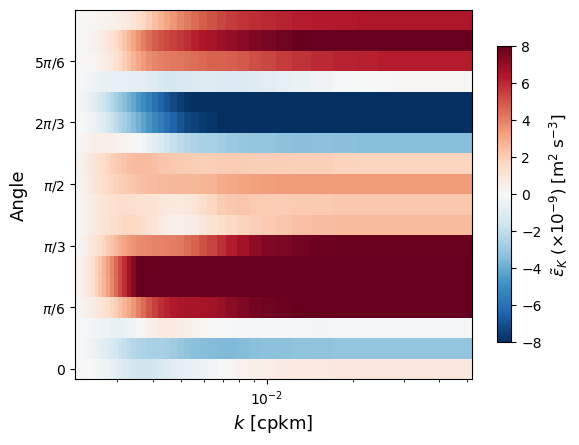

In [9]:
values = np.array([8,3,2.,.1,.06,.06])

fig, ax = plt.subplots()
im = ax.pcolormesh((piw.scale)**-1*1e3, piw.angle, piw.isel(Z=1).mean('nmemb')*1e9,
                   vmax=values[reg], vmin=-values[reg],
                   cmap='RdBu_r', rasterized=True
                  )
ax.set_xscale('log')
ax.set_xlabel(r"$k$ [cpkm]", fontsize=13)
ax.set_ylabel(r"Angle", fontsize=13)
ax.set_yticks([piw.angle[0], piw.angle[3], piw.angle[6], piw.angle[9], piw.angle[12], piw.angle[15]])
ax.set_yticklabels(['0', r"$\pi/6$", r"$\pi/3$", r"$\pi/2$", r"$2\pi/3$", r"$5\pi/6$"])
cbar = fig.colorbar(im, ax=ax, shrink=.8)
cbar.set_label(r"$\tilde{\epsilon}_K$ ($\times 10^{-9}$) [m$^{2}$ s$^{-3}$]", fontsize=12)
plt.savefig(op.join(savedir,'Figs/KE-specflux_Region%02d_phi-K_Z452.pdf' % reg))
# plt.savefig(op.join(savedir,'Figs/KE-specflux_reenvisioned_Region%02d_phi-K_Z452.pdf' % reg))

### $$\tilde{\varepsilon}_K(\boldsymbol{\gamma},\phi,k) 
    = -\frac{1}{C_{\Xi}}\int_{k>\kappa} \mathcal{R}\left[ \langle\tilde{u'}^* (\widetilde{\boldsymbol{v}\cdot\nabla u'})\rangle + \langle\tilde{v'}^* (\widetilde{\boldsymbol{v}\cdot\nabla v'})\rangle \right] x_0^2 \kappa\, d\kappa$$

In [7]:
iiter = 1419120
# iiter = 1421280
# iiter = 1423440
dg = 0

dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=iiter, 
                     ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                           YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                           XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                           XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                          ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
if len(dsb.XG) > len(dsb.XC):
     dsb = dsb.isel(XG=slice(None,-1))

grid = Grid(dsb, periodic=[], 
            # coords={'Z': {'center': 'Z', 'outer': 'Zp1', 'left':'Zl', 'right':'Zu'},
            #         'Y': {'center': 'YC', 'left': 'YG'},
            #         'X': {'center': 'XC', 'left': 'XG'}}
           )

for nmemb in nmembs:
    if nmemb == 100:
        ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                     % (nmemb)), 
                             grid_dir=gdir,
                             prefix=['snap_diagOcn'], delta_t=2e2,
                             iters=iiter, 
                             ignore_unknown_vars=True
                            ).isel(time=0).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                               YG=slice(ys[reg]-5,ys[reg]+5),
                                               XC=slice(xs[reg]-5,xs[reg]+5),
                                               XG=slice(xs[reg]-5,xs[reg]+5)
                                              )
    else:
        ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                     % (nmemb)), 
                             grid_dir=gdir,
                             prefix=['snap_diagOcn'], delta_t=2e2,
                             iters=iiter, 
                             ignore_unknown_vars=True
                            ).isel(time=0).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                               YG=slice(ys[reg]-5,ys[reg]+5),
                                               XC=slice(xs[reg]-5,xs[reg]+5),
                                               XG=slice(xs[reg]-5,xs[reg]+5)
                                              )
        ds = xr.concat([ds, ds1], dim='nmemb')
        ds1.close()
    print(nmemb)

            # ds = ds.chunk({'nmemb':6})
ds.coords['nmemb'] = ('nmemb',nmembs)
if len(ds.XG) > len(ds.XC):
     ds = ds.isel(XG=slice(None,-1))
ds

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


<xarray.Dataset>
Dimensions:  (XC: 116, YC: 120, XG: 116, YG: 120, Z: 46, Zp1: 47, Zu: 46,
              Zl: 46, nmemb: 48)
Coordinates: (12/34)
    iter     int64 1419120
    time     timedelta64[ns] 3285 days
  * XC       (XC) >f4 290.1 290.1 290.2 290.3 290.4 ... 299.7 299.8 299.9 300.0
  * YC       (YC) >f4 32.0 32.08 32.17 32.25 32.33 ... 41.67 41.75 41.83 41.92
  * XG       (XG) >f4 290.0 290.1 290.2 290.3 290.4 ... 299.7 299.7 299.8 299.9
  * YG       (YG) >f4 32.04 32.13 32.21 32.29 32.38 ... 41.71 41.79 41.88 41.96
    ...       ...
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 120, 116), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(120, 116), meta=np.ndarray>
    rhoRef   (Z) >f4 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.044e+03
    maskInW  (YC, XG) bool dask.array<chunksize=(120, 116), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(120, 116), meta=np.ndarray>
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
Data variables:
    THETA    (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
    SALT     (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
    UVEL     (nmemb, Z, YC, XG) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
    VVEL     (nmemb, Z, YG, XC) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
    WVEL     (nmemb, Zl, YC, XC) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [8]:
up = (ds.UVEL - dsb.UVEL).where(ds.maskW!=0.)
upC = grid.interp(up,'X',boundary='extend').isel(Z=[14,18,24]).load()
vp = (ds.VVEL - dsb.VVEL).where(ds.maskS!=0.)
vpC = grid.interp(vp,'Y',boundary='extend').isel(Z=[14,18,24]).load()
wp = (ds.WVEL - dsb.WVEL)

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(


In [9]:
xA = (ds.dyG * ds.drF).reset_coords(drop=True)
yA = (ds.dxG * ds.drF).reset_coords(drop=True)

UTrans = ds.UVEL * xA * ds.hFacW
VTrans = ds.VVEL * yA * dsg.hFacS
RTrans = grid.interp(ds.WVEL,'X',boundary='extend') * ds.rAw
Auup = (grid.interp(UTrans,'X',boundary='extend')
        * grid.interp(up,'X',boundary='extend')
       )
Avup = (grid.interp(VTrans,'X',boundary='extend')
        * grid.interp(up,'Y',boundary='extend')
       )
Awup = (RTrans
        * grid.interp(up,'Z',boundary='extend')
       )
RTrans = grid.interp(ds.WVEL,'Y',boundary='extend') * ds.rAs
Auvp = (grid.interp(UTrans,'Y',boundary='extend')
        * grid.interp(vp,'X',boundary='extend')
       )
Avvp = (grid.interp(VTrans,'Y',boundary='extend')
        * grid.interp(vp,'Y',boundary='extend')
       )
Awvp = (RTrans
        * grid.interp(vp,'Z',boundary='extend')
       )
Aut = grid.interp(((grid.diff(Auup,'X',boundary='extend')
                    + grid.diff(Avup,'Y',boundary='extend')
                    - grid.diff(Awup,'Z',boundary='extend')
                   ) / ds.drF/ds.rAw
                  ).where(ds.maskW!=0.).reset_coords(drop=True),
                  'X',boundary='extend').isel(Z=[14,18,24]).compute()
Avt = grid.interp(((grid.diff(Auvp,'X',boundary='extend')
                    + grid.diff(Avvp,'Y',boundary='extend')
                    - grid.diff(Awvp,'Z',boundary='extend')
                   ) / ds.drF/ds.rAs
                  ).where(ds.maskS!=0.).reset_coords(drop=True),
                  'Y',boundary='extend').isel(Z=[14,18,24]).compute()
Aut

<xarray.DataArray (nmemb: 48, Z: 3, YC: 120, XC: 116)>
array([[[[ 8.12281655e-08, -3.55285124e-07, -3.20918730e-07, ...,
           4.00094848e-07,  9.03546251e-08, -1.73648075e-07],
         [-9.77640724e-08, -4.34177281e-07, -3.63999533e-07, ...,
           3.81154223e-07,  1.18018789e-07, -1.40185932e-07],
         [-3.15109816e-07, -4.85011412e-07, -3.67716154e-07, ...,
           3.36239736e-07,  1.73172523e-07, -1.05338689e-08],
         ...,
         [            nan,             nan,             nan, ...,
           2.16570740e-07,  2.46060125e-07,  2.62993268e-07],
         [            nan,             nan,             nan, ...,
           2.49228322e-07,  2.56955985e-07,  2.49063277e-07],
         [            nan,             nan,             nan, ...,
           6.26357064e-08,  7.29856495e-08,  6.89123638e-08]],

        [[ 2.23516849e-08, -2.18212961e-07, -1.62177173e-07, ...,
           1.23744613e-07,  9.32639352e-08,  7.70954713e-08],
         [-4.70666492e-08, -2.12862886e-07, -1.33820905e-07, ...,
           1.25661884e-07,  9.75920642e-08,  8.27552711e-08],
         [-1.17189330e-07, -1.91144196e-07, -9.73531797e-08, ...,
           1.08461052e-07,  7.23022211e-08,  5.12265821e-08],
...
           9.96332545e-08,  1.23423774e-07,  1.33068923e-07],
         [            nan,             nan,             nan, ...,
           1.09248703e-07,  1.44917990e-07,  1.66617113e-07],
         [            nan,             nan,             nan, ...,
           1.83263815e-09, -3.74323417e-09, -4.12521395e-09]],

        [[-9.50156149e-08, -9.72779333e-08, -9.40685894e-08, ...,
           1.03881233e-08,  8.18530044e-09,  1.12023617e-08],
         [-1.91425386e-07, -1.87086812e-07, -1.81989776e-07, ...,
           1.61440949e-09,  4.02620426e-09,  1.14867058e-08],
         [-1.95734771e-07, -1.94615652e-07, -1.93148679e-07, ...,
          -1.63528497e-08, -1.17405703e-08, -1.28368915e-09],
         ...,
         [            nan,             nan,             nan, ...,
           1.69910663e-08,  2.85086941e-08,  3.35271899e-08],
         [            nan,             nan,             nan, ...,
           2.50616168e-08,  3.66242716e-08,  4.00226376e-08],
         [            nan,             nan,             nan, ...,
           7.90572674e-09,  7.51356755e-11, -2.87305135e-09]]]],
      dtype=float32)
Coordinates:
  * XC       (XC) >f4 290.1 290.1 290.2 290.3 290.4 ... 299.7 299.8 299.9 300.0
  * YC       (YC) >f4 32.0 32.08 32.17 32.25 32.33 ... 41.67 41.75 41.83 41.92
  * Z        (Z) >f4 -227.6 -452.4 -1.137e+03
Dimensions without coordinates: nmemb

In [12]:
xT = grid.cumsum(ds.dxC,'X',boundary='extend'
                )
yT = grid.cumsum(ds.dyC,'Y',boundary='extend'
                )
ny, nx = xT.shape
xT = xT - xT.isel(XC=nx//2)
xT = (xT - xT.isel(YC=-1,XC=0)).values.flatten()
yT = (yT - yT.isel(YC=0)).values.flatten()
dx = ds.dxC.min().values
dy = ds.dyC.min().values
N = ds.THETA.isel(nmemb=0,Z=0).shape

xxx, yyy = np.mgrid[0:N[-1]*dx:dx, 0:N[-2]*dy:dy]
rAterp = griddata((xT, yT), ds.rA.values.flatten(),
                  (xxx, yyy) 
                 ).T

In [16]:
ss = xr.open_zarr(
    '/tank/topog/tuchida/Wavelet-spectrum/isoDiags_KE_region%02d_1967-01-01.zarr' 
                  % reg
                 ).scale / xo

Auterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                      coords={'nmemb':nmembs,'Z':upC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
Avterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
uterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                     coords={'nmemb':nmembs,'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                     coords={'nmemb':nmembs,'Z':vpC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
        

for iz in range(len(upC.Z)):
    for nn in range(len(nmembs)):
        uterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                       (upC*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                       (xxx, yyy) 
                                      ).T 
        vterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                       (vpC*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                       (xxx, yyy) 
                                      ).T
        Auterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                        (Aut*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                        (xxx, yyy) 
                                       ).T 
        Avterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                        (Avt*ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                        (xxx, yyy) 
                                       ).T 

uterp = uterp / rAterp
vterp = vterp / rAterp        
Auterp = Auterp / rAterp
Avterp = Avterp / rAterp


iso_UA = xwavelet.wvlt_cross_spectrum(
                    uterp, Auterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
iso_VA = xwavelet.wvlt_cross_spectrum(
                    vterp, Avterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )

        
dsave = iso_UA.to_dataset(name='iso_uA')
dsave['iso_vA'] = iso_VA
dsave.encoding = {}
fname = op.join(savedir,'isoDiags-EKEtransfer_region%02d_%010d.zarr' % (reg,iiter))
dsave.to_zarr(fname, mode='w')
dsave.close()

In [13]:
Auinterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                      coords={'nmemb':nmembs,'Z':upC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
Avinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                      coords={'nmemb':nmembs,'Z':vpC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
uinterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                     coords={'nmemb':nmembs,'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vinterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                     coords={'nmemb':nmembs,'Z':vpC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
        

for iz in range(len(upC.Z)):
    for nn in range(len(nmembs)):
        uinterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                       (upC.interpolate_na(dim='YC'
                                                          ).interpolate_na(dim='XC'
                                                                          ).fillna(0.)
                                        * ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                       (xxx, yyy) 
                                      ).T 
        vinterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                       (vpC.interpolate_na(dim='YC'
                                                          ).interpolate_na(dim='XC'
                                                                          ).fillna(0.)
                                        * ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                       (xxx, yyy) 
                                      ).T
        Auinterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                        (Aut.interpolate_na(dim='YC'
                                                           ).interpolate_na(dim='XC'
                                                                           ).fillna(0.)
                                         * ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                        (xxx, yyy) 
                                       ).T 
        Avinterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                        (Avt.interpolate_na(dim='YC'
                                                           ).interpolate_na(dim='XC'
                                                                           ).fillna(0.)
                                         * ds.rA).isel(nmemb=nn,Z=iz).values.flatten(),
                                        (xxx, yyy) 
                                       ).T 

uinterp = uinterp / rAterp
vinterp = vinterp / rAterp        
Auinterp = Auinterp / rAterp
Avinterp = Avinterp / rAterp

In [16]:
cs_uA = xrft.cross_spectrum(
                        uinterp.chunk({'YC':-1,'XC':-1}), 
                        Auinterp.chunk({'YC':-1,'XC':-1}), 
                        dim=["YC", "XC"], window='hann', true_phase=True, 
                        window_correction=True
            )
cs_vA = xrft.cross_spectrum(
                        vinterp.chunk({'YC':-1,'XC':-1}), 
                        Avinterp.chunk({'YC':-1,'XC':-1}), 
                        dim=["YC", "XC"], window='hann', true_phase=True, 
                        window_correction=True
            )

dsave = cs_uA.to_dataset(name='cs_uA')
dsave['cs_vA'] = cs_vA
dsave.encoding = {}
fname = op.join(savedir,'crossFourierDiags-EKEtransfer_region%02d_%010d.zarr'
                % (reg,iiter))
dsave.to_zarr(fname, mode='w')
dsave.close()

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


<xarray.DataArray (nmemb: 48, freq_r: 17)>
array([[-1.05121334e-07,  2.75395745e-08,  8.53369986e-09,
         1.42180917e-09, -4.35997333e-10, -2.33095287e-10,
        -2.76267891e-10, -1.12582183e-10, -3.21054207e-11,
        -7.85232666e-12, -7.43450077e-12, -4.27245167e-12,
        -2.31880212e-12, -1.31128753e-12, -6.22402569e-13,
        -2.13774791e-13, -7.26919671e-14],
       [-3.63726819e-08, -1.54909032e-08, -6.06087377e-09,
        -1.14972216e-09, -8.93622709e-12,  2.93457261e-10,
         1.53106499e-10,  1.79580235e-10,  1.50015771e-10,
         6.26322833e-11,  2.39623875e-11, -1.40579108e-12,
        -4.16700675e-12, -2.15473636e-12, -7.70203852e-13,
        -2.81955564e-13, -5.81056169e-14],
       [-1.63389432e-09, -7.38298549e-11, -3.66646784e-10,
         2.65919684e-10,  1.66729410e-09,  2.25510790e-09,
         1.47324779e-09,  5.78134366e-10,  1.63747581e-10,
        -1.74769406e-12, -5.10815963e-11, -3.92633962e-11,
        -1.93188836e-11, -7.85024226e-12, -3.

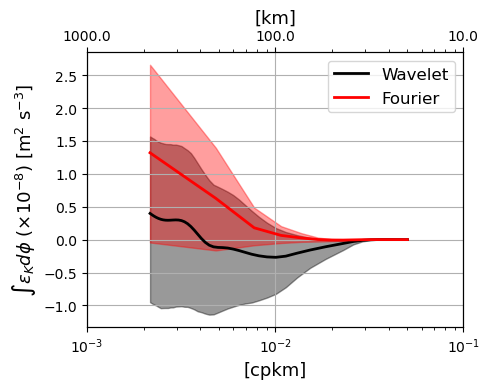

In [29]:
nz = 1

for reg in range(len(xs)-5):
    ds4 = xr.open_dataset(op.join(savedir,'isoDiags-EKEtransfer_region%02d_%010d.zarr' 
                                  % (reg,iiter)))
    dks = xr.DataArray(np.abs(np.diff(ds4.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(ds4.scale[1:].data + ds4.scale[:-1].data)}
                      ).interp(scale=ds4.scale, kwargs={"fill_value": "extrapolate"})
    Ak = (ds4.iso_uA + ds4.iso_vA).isel(Z=nz)

    piw = (((Ak) * dks).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
           * np.diff(ds4.angle)[0]*2)
    datas = (piw, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Pwres = bootstrap(datas, np.mean, confidence_level=0.95,
                      # n_resamples=1000,
                      random_state=rng)
    
    ds4f = xr.open_dataset(op.join(savedir,
                                'crossFourierDiags-EKEtransfer_region%02d_%010d.zarr' 
                                   % (reg,iiter)))
    Ak = (ds4f.cs_uA + ds4f.cs_vA).isel(Z=nz)
    iso_cs = xrft.isotropize(
        Ak.real, ["freq_YC","freq_XC"], truncate=True).compute() * 2*np.pi
    pif = (iso_cs*np.abs(np.diff(iso_cs.freq_r)[0])
          )[...,::-1].cumsum('freq_r')[...,::-1].compute()
    datas = (pif, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Pfres = bootstrap(datas, np.mean, confidence_level=0.95,
                      # n_resamples=1000,
                      random_state=rng)
    print(pif)
    
    fig, ax = plt.subplots(figsize=(5,4))
    fig.set_tight_layout(True)
    # ax2 = ax.twinx()
    ax3 = ax.twiny()
    
    ax.fill_between((ds4.scale)**-1*1e3, -Pwres.confidence_interval.low*1e8, 
                    -Pwres.confidence_interval.high*1e8, 
                    alpha=.4, color='k')
    ax.fill_between(iso_cs.freq_r*1e3, -Pfres.confidence_interval.low*1e8, 
                    -Pfres.confidence_interval.high*1e8, 
                    alpha=.38, color='r')
    
    ax.plot((ds4.scale)**-1*1e3, -piw.mean(['nmemb'])*1e8,
            'k', lw=2, label=r"Wavelet")
    ax.plot(iso_cs.freq_r*1e3, -pif.mean(['nmemb'])*1e8,
            'r', lw=2, label=r"Fourier")
    
    ax.set_xscale('log')

    ax3.set_xscale('log')
    ax.set_xlim([1e-3,1e-1])
    ax3.set_xlim([1e-3,1e-1])
    ax3.set_xticks([1e-3,1e-2,1e-1])
    ax3.set_xticklabels([1e3,1e2,1e1])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax3.set_xlabel(r"[km]", fontsize=13)
    ax.set_ylabel(r"$\int\epsilon_Kd\phi$ ($\times 10^{-8}$) [m$^2$ s$^{-3}$]", 
                  fontsize=13)
    ax.grid(True)
    if reg == 0:
        ax.legend(loc='upper right', fontsize=12)
    plt.savefig(op.join(savedir,
                    'Figs/WvsF_EKE-specflux_Region%02d_Z452.pdf' 
                        % reg))
    plt.show()

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


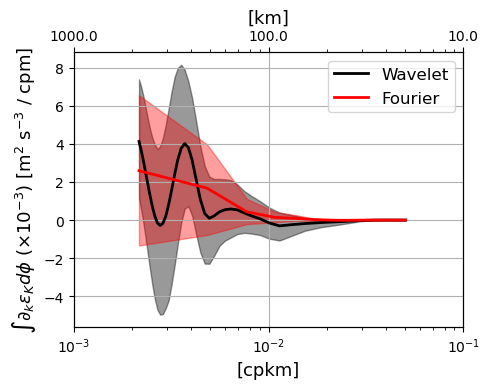

In [30]:
nz = 1

for reg in range(len(xs)-5):
    ds4 = xr.open_dataset(op.join(savedir,'isoDiags-EKEtransfer_region%02d_%010d.zarr' 
                                  % (reg,iiter)))
    dks = xr.DataArray(np.abs(np.diff(ds4.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(ds4.scale[1:].data + ds4.scale[:-1].data)}
                      ).interp(scale=ds4.scale, kwargs={"fill_value": "extrapolate"})
    Ak = ((ds4.iso_uA + ds4.iso_vA).isel(Z=nz).sum('angle')
          * np.diff(ds4.angle)[0]*2)
    datas = (Ak, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Pwres = bootstrap(datas, np.mean, confidence_level=0.95,
                      # n_resamples=1000,
                      random_state=rng)
    
    ds4f = xr.open_dataset(op.join(savedir,
                                'crossFourierDiags-EKEtransfer_region%02d_%010d.zarr' 
                                   % (reg,iiter)))
    Akf = (ds4f.cs_uA + ds4f.cs_vA).isel(Z=nz)
    iso_cs = xrft.isotropize(
        Akf.real, ["freq_YC","freq_XC"], truncate=True).compute() * 2*np.pi
    datas = (iso_cs, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Pfres = bootstrap(datas, np.mean, confidence_level=0.95,
                      # n_resamples=1000,
                      random_state=rng)
    
    fig, ax = plt.subplots(figsize=(5,4))
    fig.set_tight_layout(True)
    # ax2 = ax.twinx()
    ax3 = ax.twiny()
    
    ax.fill_between((ds4.scale)**-1*1e3, -Pwres.confidence_interval.low*1e3, 
                    -Pwres.confidence_interval.high*1e3, 
                    alpha=.4, color='k')
    ax.fill_between(iso_cs.freq_r*1e3, -Pfres.confidence_interval.low*1e3, 
                    -Pfres.confidence_interval.high*1e3, 
                    alpha=.38, color='r')
    
    ax.plot((ds4.scale)**-1*1e3, -Ak.mean(['nmemb'])*1e3,
            'k', lw=2, label=r"Wavelet")
    ax.plot(iso_cs.freq_r*1e3, -iso_cs.mean(['nmemb'])*1e3,
            'r', lw=2, label=r"Fourier")
    
    ax.set_xscale('log')

    ax3.set_xscale('log')
    ax.set_xlim([1e-3,1e-1])
    ax3.set_xlim([1e-3,1e-1])
    ax3.set_xticks([1e-3,1e-2,1e-1])
    ax3.set_xticklabels([1e3,1e2,1e1])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax3.set_xlabel(r"[km]", fontsize=13)
    ax.set_ylabel(r"$\int\partial_k\epsilon_Kd\phi$ ($\times 10^{-3}$) [m$^2$ s$^{-3}$ / cpm]", 
                  fontsize=13)
    ax.grid(True)
    if reg == 0:
        ax.legend(loc='upper right', fontsize=12)
    plt.savefig(op.join(savedir,
                    'Figs/WvsF_EKE-spectrans_Region%02d_Z452.pdf' 
                        % reg))
    plt.show()

## $$\big\langle\boldsymbol{v}\cdot\nabla u - \langle\boldsymbol{v}\rangle\cdot\nabla\langle u\rangle\big\rangle = \langle\boldsymbol{v}'\cdot\nabla u'\rangle$$
## $$\boldsymbol{v}\cdot\nabla\frac{v'^2}{2} = v'\langle\boldsymbol{v}\rangle\cdot\nabla v' + v'\boldsymbol{v}'\cdot\nabla v' = v'(\boldsymbol{v}\cdot\nabla v)'
- v'\boldsymbol{v}'\cdot\nabla\langle\boldsymbol{v}\rangle$$

In [32]:
reg = 0
iiter = 1419120
# iiter = 1421280
# iiter = 1423440
dg = 0

dsb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                      grid_dir=gdir,
                      prefix=['snap_diagOcn'], delta_t=2e2,
                      iters=iiter, 
                     ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                           YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                           XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                           XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                          ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
# dsUmb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
#                         grid_dir=gdir,
#                         prefix=['diagUm'], delta_t=2e2,
#                         iters=iiter, 
#                         ignore_unknown_vars=True
#                        ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
#                              YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
#                              XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
#                              XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
#                             ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)
dsVmb = open_mdsdataset(op.join(ddir,'ensm/run1967/ocn'), 
                        grid_dir=gdir,
                        prefix=['diagVm'], delta_t=2e2,
                        iters=iiter, 
                        ignore_unknown_vars=True
                       ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                             YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                             XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                             XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                            ).chunk({'Z':1,'Zl':1,'Zu':1,'Zp1':1}).isel(time=0)

dsm = xr.open_zarr(op.join(spec,'Snaps_Tot-Adv_EnsMean/%010d.zarr' % iiter)
                  ).sel(YC=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                        YG=slice(ys[reg]-5-dg/12,ys[reg]+5+dg/12),
                        XC=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12),
                        XG=slice(xs[reg]-5-dg/12,xs[reg]+5+dg/12)
                       ).chunk({'Z':1})

if len(dsb.XG) > len(dsb.XC):
     dsb = dsb.isel(XG=slice(None,-1))
# if len(dsUmb.XG) > len(dsUmb.XC):
#      dsUmb = dsUmb.isel(XG=slice(None,-1))
# if len(dsVmb.XG) > len(dsVmb.XC):
#      dsVmb = dsVmb.isel(XG=slice(None,-1))

grid = Grid(dsb, periodic=[], 
            # coords={'Z': {'center': 'Z', 'outer': 'Zp1', 'left':'Zl', 'right':'Zu'},
            #         'Y': {'center': 'YC', 'left': 'YG'},
            #         'X': {'center': 'XC', 'left': 'XG'}}
           )

for nmemb in nmembs:
    if nmemb == 100:
        ds = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                     % (nmemb)), 
                             grid_dir=gdir,
                             prefix=['snap_diagOcn'], delta_t=2e2,
                             iters=iiter, 
                             ignore_unknown_vars=True
                            ).isel(time=0).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                               YG=slice(ys[reg]-5,ys[reg]+5),
                                               XC=slice(xs[reg]-5,xs[reg]+5),
                                               XG=slice(xs[reg]-5,xs[reg]+5)
                                              )
        dsU = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                     % (nmemb)), 
                             grid_dir=gdir,
                             prefix=['diagUm'], delta_t=2e2,
                             iters=iiter, 
                             ignore_unknown_vars=True
                            ).isel(time=0).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                               YG=slice(ys[reg]-5,ys[reg]+5),
                                               XC=slice(xs[reg]-5,xs[reg]+5),
                                               XG=slice(xs[reg]-5,xs[reg]+5)
                                              )
        dsV = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                     % (nmemb)), 
                             grid_dir=gdir,
                             prefix=['diagVm'], delta_t=2e2,
                             iters=iiter, 
                             ignore_unknown_vars=True
                            ).isel(time=0).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                               YG=slice(ys[reg]-5,ys[reg]+5),
                                               XC=slice(xs[reg]-5,xs[reg]+5),
                                               XG=slice(xs[reg]-5,xs[reg]+5)
                                              )
    else:
        ds1 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                     % (nmemb)), 
                             grid_dir=gdir,
                             prefix=['snap_diagOcn'], delta_t=2e2,
                             iters=iiter, 
                             ignore_unknown_vars=True
                            ).isel(time=0).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                               YG=slice(ys[reg]-5,ys[reg]+5),
                                               XC=slice(xs[reg]-5,xs[reg]+5),
                                               XG=slice(xs[reg]-5,xs[reg]+5)
                                              )
        ds = xr.concat([ds, ds1], dim='nmemb')
        ds1.close()
        ds2 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                     % (nmemb)), 
                             grid_dir=gdir,
                             prefix=['diagUm'], delta_t=2e2,
                             iters=iiter, 
                             ignore_unknown_vars=True
                            ).isel(time=0).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                               YG=slice(ys[reg]-5,ys[reg]+5),
                                               XC=slice(xs[reg]-5,xs[reg]+5),
                                               XG=slice(xs[reg]-5,xs[reg]+5)
                                              )
        dsU = xr.concat([dsU, ds2], dim='nmemb')
        ds2.close()
        ds3 = open_mdsdataset(op.join(ddir,'memb%03d/run1967/ocn/' 
                                     % (nmemb)), 
                             grid_dir=gdir,
                             prefix=['diagVm'], delta_t=2e2,
                             iters=iiter, 
                             ignore_unknown_vars=True
                            ).isel(time=0).sel(YC=slice(ys[reg]-5,ys[reg]+5),
                                               YG=slice(ys[reg]-5,ys[reg]+5),
                                               XC=slice(xs[reg]-5,xs[reg]+5),
                                               XG=slice(xs[reg]-5,xs[reg]+5)
                                              )
        dsV = xr.concat([dsV, ds3], dim='nmemb')
        ds3.close()
    print(nmemb)

            # ds = ds.chunk({'nmemb':6})
ds.coords['nmemb'] = ('nmemb',nmembs)
# dsV.coords['nmemb'] = ('nmemb',nmembs)
if len(ds.XG) > len(ds.XC):
     ds = ds.isel(XG=slice(None,-1))
if len(dsU.XG) > len(dsU.XC):
     dsU = dsU.isel(XG=slice(None,-1))
if len(dsV.XG) > len(dsV.XC):
     dsV = dsV.isel(XG=slice(None,-1))
        
ds

100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147


<xarray.Dataset>
Dimensions:  (XC: 116, YC: 120, XG: 116, YG: 120, Z: 46, Zp1: 47, Zu: 46,
              Zl: 46, nmemb: 48)
Coordinates: (12/34)
    iter     int64 1419120
    time     timedelta64[ns] 3285 days
  * XC       (XC) >f4 290.1 290.1 290.2 290.3 290.4 ... 299.7 299.8 299.9 300.0
  * YC       (YC) >f4 32.0 32.08 32.17 32.25 32.33 ... 41.67 41.75 41.83 41.92
  * XG       (XG) >f4 290.0 290.1 290.2 290.3 290.4 ... 299.7 299.7 299.8 299.9
  * YG       (YG) >f4 32.04 32.13 32.21 32.29 32.38 ... 41.71 41.79 41.88 41.96
    ...       ...
    maskS    (Z, YG, XC) bool dask.array<chunksize=(46, 120, 116), meta=np.ndarray>
    maskInC  (YC, XC) bool dask.array<chunksize=(120, 116), meta=np.ndarray>
    rhoRef   (Z) >f4 1.021e+03 1.021e+03 1.021e+03 ... 1.044e+03 1.044e+03
    maskInW  (YC, XG) bool dask.array<chunksize=(120, 116), meta=np.ndarray>
    maskInS  (YG, XC) bool dask.array<chunksize=(120, 116), meta=np.ndarray>
  * nmemb    (nmemb) int64 100 101 102 103 104 105 ... 142 143 144 145 146 147
Data variables:
    THETA    (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
    SALT     (nmemb, Z, YC, XC) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
    UVEL     (nmemb, Z, YC, XG) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
    VVEL     (nmemb, Z, YG, XC) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
    WVEL     (nmemb, Zl, YC, XC) float32 dask.array<chunksize=(1, 46, 120, 116), meta=np.ndarray>
Attributes:
    Conventions:  CF-1.6
    title:        netCDF wrapper of MITgcm MDS binary data
    source:       MITgcm
    history:      Created by calling `open_mdsdataset(grid_dir='/tank/chaocea...

In [33]:
dAuup_true = grid.interp(dsU.Um_Advec - dsU.Um_Cori
                         - dsm.Um_Advec + dsU.Um_Cori.mean('nmemb'),
                         'X',boundary='extend'
                        ).where(ds.maskC!=0.).reset_coords(drop=True).isel(Z=[0,18]).compute()
dAuvp_true = grid.interp(dsV.Vm_Advec - dsV.Vm_Cori
                         - dsm.Vm_Advec + dsV.Vm_Cori.mean('nmemb'),
                         'Y',boundary='extend'
                        ).where(ds.maskC!=0.).reset_coords(drop=True).isel(Z=[0,18]).compute()

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 48
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 48
  result = blockwise(


In [34]:
ub = dsb.UVEL
vb = dsb.VVEL
wb = dsb.WVEL
up = ds.UVEL - ub
vp = ds.VVEL - vb
wp = ds.WVEL - wb

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/dask/array/core.py:4806: PerformanceWarning: Increasing number of chunks by factor of 46
  result = blockwise(


In [35]:
xA = (ds.dyG * ds.drF).reset_coords(drop=True)
yA = (ds.dxG * ds.drF).reset_coords(drop=True)

uTrans = up * xA
vTrans = vp * yA
rTrans = grid.interp(wp,'X',boundary='extend') * ds.rAw
Auub = (grid.interp(uTrans,'X',boundary='extend')
        * grid.interp(ub,'X',boundary='extend')
       )
Avub = (grid.interp(vTrans,'X',boundary='extend')
        * grid.interp(ub,'Y',boundary='extend')
       )
Awub = (rTrans
        * grid.interp(ub,'Z',boundary='extend')
       )

rTrans = grid.interp(wp,'Y',boundary='extend') * ds.rAs
Auvb = (grid.interp(uTrans,'Y',boundary='extend')
        * grid.interp(vb,'X',boundary='extend')
       )
Avvb = (grid.interp(vTrans,'Y',boundary='extend')
        * grid.interp(vb,'Y',boundary='extend')
       )
Awvb = (rTrans
        * grid.interp(vb,'Z',boundary='extend')
       )
Aut = grid.interp(((grid.diff(Auub,'X',boundary='extend')
                    + grid.diff(Avub,'Y',boundary='extend')
                    - grid.diff(Awub,'Z',boundary='extend')
                   ) / ds.drF/ds.rAw
                  ).reset_coords(drop=True),
                  'X',boundary='extend').where(ds.maskC!=0.).isel(Z=[0,18]).compute()
Avt = grid.interp(((grid.diff(Auvb,'X',boundary='extend')
                    + grid.diff(Avvb,'Y',boundary='extend')
                    - grid.diff(Awvb,'Z',boundary='extend')
                   ) / ds.drF/ds.rAs
                  ).reset_coords(drop=True),
                  'Y',boundary='extend').where(ds.maskC!=0.).isel(Z=[0,18]).compute()

In [36]:
UTrans = ub * xA
VTrans = vb * yA
RTrans = wb * ds.rA
AUup = (UTrans
        * up
       )
AVup = (VTrans
        * grid.interp(grid.interp(up,'Y',boundary='extend'),'X',boundary='extend')
       )
AWup = (RTrans
        * grid.interp(grid.interp(up,'Z',boundary='extend'),'X',boundary='extend')
       )
dAUup = ((grid.diff(AUup,'X',boundary='extend')
          + grid.diff(AVup,'Y',boundary='extend')
          - grid.diff(AWup,'Z',boundary='extend')
         ) / ds.drF/ds.rA
        ).where(ds.maskC!=0.).reset_coords(drop=True).isel(Z=[0,18]).load()

rTrans = wp * ds.rA
Auup = (uTrans
        * up
       )
Avup = (vTrans
        * grid.interp(grid.interp(up,'Y',boundary='extend'),'X',boundary='extend')
       )
Awup = (rTrans
        * grid.interp(grid.interp(up,'Z',boundary='extend'),'X',boundary='extend')
       )
dAuup = ((grid.diff(Auup,'X',boundary='extend')
          + grid.diff(Avup,'Y',boundary='extend')
          - grid.diff(Awup,'Z',boundary='extend')
         ) / ds.drF/ds.rA
        ).where(ds.maskC!=0.).reset_coords(drop=True).isel(Z=[0,18]).load()
dAuup_true = dAuup_true + (Aut + dAUup)

# dAUup, dAuup, dAuup_true

In [37]:
AUvp = (UTrans
        * grid.interp(grid.interp(vp,'Y',boundary='extend'),'X',boundary='extend')
       )
AVvp = (VTrans
        * vp
       )
AWvp = (RTrans
        * grid.interp(grid.interp(vp,'Z',boundary='extend'),'Y',boundary='extend')
       )
dAUvp = ((grid.diff(AUvp,'X',boundary='extend')
          + grid.diff(AVvp,'Y',boundary='extend')
          - grid.diff(AWvp,'Z',boundary='extend')
         ) / ds.drF/ds.rA
        ).where(ds.maskC!=0.).reset_coords(drop=True).isel(Z=[0,18]).load()

Auvp = (uTrans
        * grid.interp(grid.interp(vp,'Y',boundary='extend'),'X',boundary='extend')
       )
Avvp = (vTrans
        * vp
       )
Awvp = (rTrans
        * grid.interp(grid.interp(vp,'Z',boundary='extend'),'Y',boundary='extend')
       )
dAuvp = ((grid.diff(Auvp,'X',boundary='extend')
          + grid.diff(Avvp,'Y',boundary='extend')
          - grid.diff(Awvp,'Z',boundary='extend')
         ) / ds.drF/ds.rA
        ).where(ds.maskC!=0.).reset_coords(drop=True).isel(Z=[0,18]).load()
dAuvp_true = dAuvp_true + (Avt + dAUvp)

# dAUvp, dAuvp, dAuvp_true

In [38]:
upC = grid.interp(up,'X',boundary='extend'
                 ).where(ds.maskC!=0.).reset_coords(drop=True).isel(Z=[0,18]).load()
vpC = grid.interp(vp,'Y',boundary='extend'
                 ).where(ds.maskC!=0.).reset_coords(drop=True).isel(Z=[0,18]).load()

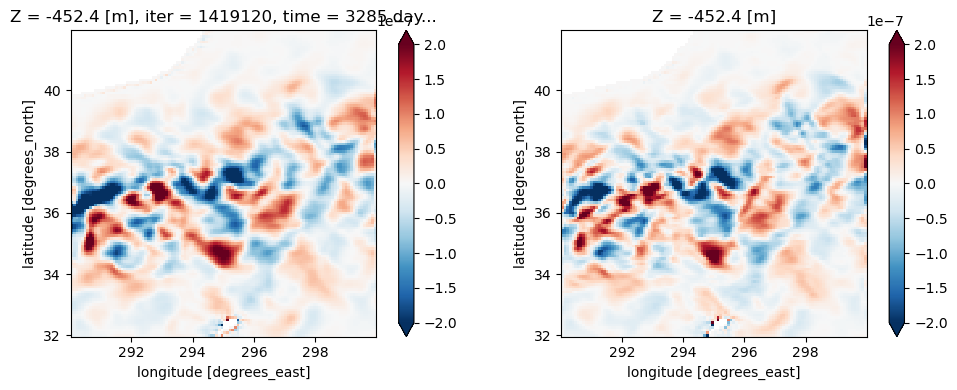

In [47]:
fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)
fig.set_tight_layout(True)

(vpC*dAuvp_true).isel(Z=1).mean('nmemb').plot(ax=ax1, rasterized=True, vmax=2e-7)
(-vpC*dAuvp).mean('nmemb').isel(Z=1).plot(ax=ax2, rasterized=True, vmax=2e-7)

ax1.set_aspect('equal')
ax2.set_aspect('equal')

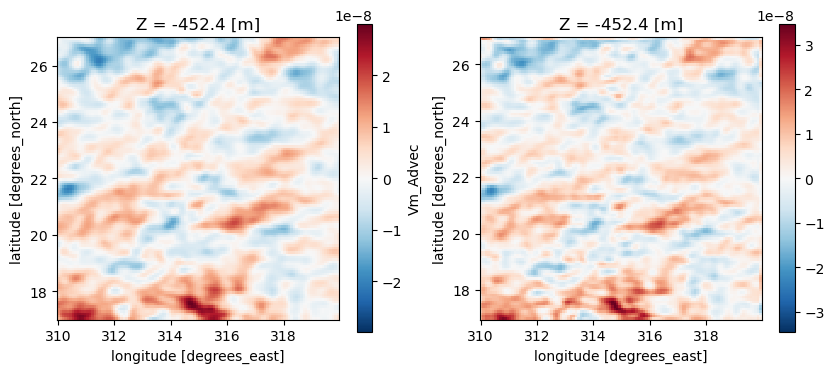

In [62]:
fig, (ax1,ax2) = plt.subplots(figsize=(10,4), nrows=1, ncols=2)

dAuvp_true.isel(Z=1).plot(ax=ax1, rasterized=True)
(-dAuvp).mean('nmemb').isel(Z=1).plot(ax=ax2, rasterized=True)

ax1.set_aspect('equal')
ax2.set_aspect('equal')

In [40]:
xT = grid.cumsum(ds.dxC,'X',boundary='extend'
                )
yT = grid.cumsum(ds.dyC,'Y',boundary='extend'
                )
ny, nx = xT.shape
xT = xT - xT.isel(XC=nx//2)
xT = (xT - xT.isel(YC=-1,XC=0)).values.flatten()
yT = (yT - yT.isel(YC=0)).values.flatten()
dx = ds.dxC.min().values
dy = ds.dyC.min().values
N = ds.THETA.isel(nmemb=0,Z=0).shape

xxx, yyy = np.mgrid[0:N[-1]*dx:dx, 0:N[-2]*dy:dy]
ntheta = 36
ss = xr.open_zarr(
    '/tank/topog/tuchida/Wavelet-spectrum/isoDiags_KE_region%02d_1967-01-01.zarr' 
                  % reg).scale/xo
# ss = xr.open_zarr(
#     '/tank/topog/tuchida/Wavelet-spectrum/isoDiags_KE_region%02d_%010d.zarr' 
#                   % (reg,iiter)).scale/xo
# ss0 = xr.DataArray(np.linspace(2*np.maximum(dx,dy),10*xo,30)/xo, dims=['scale'], 
#                   coords={'scale':np.linspace(2*dx,10*xo,30)/xo}
#                  )
ss

<xarray.DataArray 'scale' (scale: 47)>
array([9.24825986, 9.02129302, 8.79432618, 8.56735935, 8.34039251,
       8.11342567, 7.88645884, 7.659492  , 7.43252516, 7.20555832,
       6.97859149, 6.75162465, 6.52465781, 6.29769098, 6.07072414,
       5.8437573 , 5.61679047, 5.38982363, 5.16285679, 4.93588995,
       4.70892312, 4.48195628, 4.25498944, 4.02802261, 3.80105577,
       3.57408893, 3.3471221 , 3.12015526, 2.89318842, 2.66622158,
       2.43925475, 2.21228791, 1.98532107, 1.75835424, 1.5313874 ,
       1.30442056, 1.07745373, 0.87054724, 0.76886874, 0.68787468,
       0.6226582 , 0.5690005 , 0.52386193, 0.48441461, 0.45082619,
       0.42189398, 0.39655321])
Coordinates:
  * scale    (scale) float64 4.624e+05 4.511e+05 ... 2.109e+04 1.983e+04

In [41]:
rAterp = griddata((xT, yT), ds.rA.values.flatten(),
                  (xxx, yyy) 
                 ).T

In [42]:
uterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                     coords={'nmemb':nmembs,'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
vterp = xr.DataArray(np.ones_like(vpC), dims=vpC.dims,
                     coords={'nmemb':nmembs,'Z':vpC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )

for iz in range(len(upC.Z)):
    for nn in range(len(nmembs)):
        uterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT),
                                              (upC*ds.rA
                                              ).isel(nmemb=nn,Z=iz).values.flatten(),
                                              (xxx, yyy) 
                                             ).T 
        vterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                              (vpC*ds.rA
                                              ).isel(nmemb=nn,Z=iz).values.flatten(),
                                              (xxx, yyy) 
                                             ).T 
        
uterp = uterp / rAterp
vterp = vterp / rAterp

In [43]:
# dUuterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
#                      coords={'nmemb':nmembs,'Z':upC.Z,
#                              'YC':np.arange(0,N[-2]*dy,dy),
#                              'XC':np.arange(0,N[-1]*dx,dx)}
#                     )
duuterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                     coords={'nmemb':nmembs,'Z':upC.Z,
                             'YC':np.arange(0,N[-2]*dy,dy),
                             'XC':np.arange(0,N[-1]*dx,dx)}
                    )
# dUvterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
#                      coords={'nmemb':nmembs,'Z':upC.Z,
#                              'YC':np.arange(0,N[-2]*dy,dy),
#                              'XC':np.arange(0,N[-1]*dx,dx)}
#                     )
duvterp = xr.DataArray(np.ones_like(upC), dims=upC.dims,
                      coords={'nmemb':nmembs,'Z':upC.Z,
                              'YC':np.arange(0,N[-2]*dy,dy),
                              'XC':np.arange(0,N[-1]*dx,dx)}
                     )
                
for iz in range(len(upC.Z)):
    for nn in range(len(nmembs)):
        # dUuterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
        #                                         (dAUup*ds.rA
        #                                         ).isel(nmemb=nn,Z=iz).values.flatten(),
        #                                         (xxx, yyy) 
        #                                        ).T 
        duuterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                                (dAuup_true*ds.rA
                                                ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T
        # dUvterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
        #                                         (dAUvp*ds.rA
        #                                         ).isel(nmemb=nn,Z=iz).values.flatten(),
        #                                         (xxx, yyy) 
        #                                        ).T 
        duvterp[dict(nmemb=nn,Z=iz)] = griddata((xT, yT), 
                                                (dAuvp_true*ds.rA
                                                ).isel(nmemb=nn,Z=iz).values.flatten(),
                                                (xxx, yyy) 
                                               ).T 

# dUuterp = dUuterp / rAterp
duuterp = duuterp / rAterp
# dUvterp = dUvterp / rAterp
duvterp = duvterp / rAterp
            

# iso_uUu = xwavelet.wvlt_cross_spectrum(
#                     uterp, dUuterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
#         )
iso_uuu = xwavelet.wvlt_cross_spectrum(
                    uterp, duuterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )
# iso_vUv = xwavelet.wvlt_cross_spectrum(
#                     vterp, dUvterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
#         )
iso_vuv = xwavelet.wvlt_cross_spectrum(
                    vterp, duvterp, ss, dim=["YC", "XC"], xo=xo, ntheta=ntheta
        )

dsave = iso_uuu.to_dataset(name='iso_uuu')
# dsave['iso_uuu'] = iso_uuu
# dsave['iso_vUv'] = iso_vUv
dsave['iso_vuv'] = iso_vuv
dsave.encoding = {}
fname = op.join(spec,'Points/%s/%010d/isoDiags_u-v-adv_eddies-as-residual.zarr' 
                % (sreg[reg],iiter))
dsave.to_zarr(fname, mode='w')
dsave.close()

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xwavelet/wavelet.py:313: FutureWarning: This function has been renamed and will disappear in the future. Please use `cross_spectrum` instead.
  warnings.warn(msg, FutureWarning)


/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


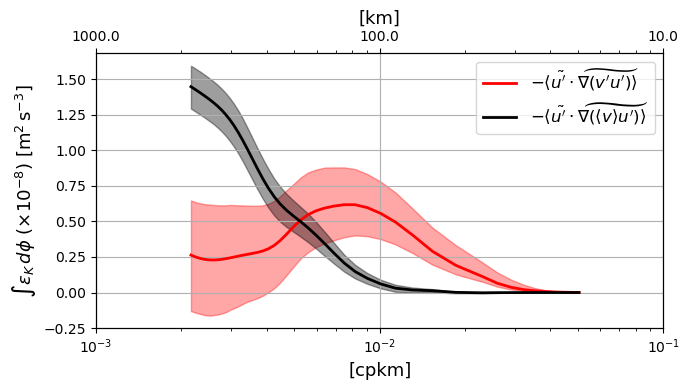

In [54]:
iZ = 1

for reg in range(1):
    ds5 = xr.open_dataset(op.join(spec,'Points/%s/%010d/isoDiags_u-v-adv.zarr' 
                                  % (sreg[reg],iiter))).isel(Z=iZ)

    ns = 1
    
    for ny in range(-ns,ns+1):
        for nx in range(-ns,ns+1):
            if ny == 0 and nx == 0:
                pass
            # elif ny == -1 and nx == -1:
            #     pass
            else:
                if ny < 0:
                    if nx < 0:
                        # try:
                        ds5  = xr.concat([ds5,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u-v-adv_-%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                    np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    else:
                        # try:
                        ds5  = xr.concat([ds5,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u-v-adv_-%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                    np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                else:
                    if nx < 0:
                        # try:
                        ds5  = xr.concat([ds5,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u-v-adv_%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                    np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    else:
                        # try:
                        ds5  = xr.concat([ds5,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u-v-adv_%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                    np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                        
    dks = xr.DataArray(np.abs(np.diff(ds5.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(ds5.scale[1:].data + ds5.scale[:-1].data)}
                      ).interp(scale=ds5.scale, kwargs={"fill_value": "extrapolate"})

    SPu = ds4.iso_SPu
    SPv = ds4.iso_SPv
    SP = (SPu + SPv)
    Ak = (ds0.iso_uA + ds1.iso_vA
          # - MtE
          + SP
         )
    Abk = -(ds5.iso_uUu + ds5.iso_vUv)
    # Apk = -(ds0.iso_uuu + ds0.iso_vuv)
    Apk = Ak - Abk

    pipw = ((Apk * dks).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
           * np.diff(ds5.angle)[0]*2)
    datas = (pipw, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Pwpres = bootstrap(datas, np.mean, confidence_level=0.95,
                       # n_resamples=100,
                       random_state=rng)
    pibw = ((Abk * dks).sum('angle')[...,::-1].cumsum('scale')[...,::-1].compute() 
           * np.diff(ds5.angle)[0]*2)
    datas = (pibw, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Pwbres = bootstrap(datas, np.mean, confidence_level=0.95,
                       # n_resamples=100,
                       random_state=rng)
    
    
    fig, ax = plt.subplots(figsize=(7,4))
    fig.set_tight_layout(True)
    # ax2 = ax.twinx()
    ax3 = ax.twiny()
    
    ax.fill_between((ds0.scale)**-1*1e3, Pwpres.confidence_interval.low*1e8, 
                    Pwpres.confidence_interval.high*1e8, 
                    alpha=.35, color='r')
    ax.fill_between((ds0.scale)**-1*1e3, Pwbres.confidence_interval.low*1e8, 
                    Pwbres.confidence_interval.high*1e8, 
                    alpha=.38, color='k')
    
#             ax.plot(np.linspace(1e-3,5e-2,10), np.zeros(10), 'k', alpha=.6, lw=1)
    # ax.plot((ds0.scale)**-1*1e3, piw.isel(angle=0,Z=0).mean(['nmemb'])*1e8,
    #         'r', lw=2, label=r"Zonal")
    # ax.plot((ds0.scale)**-1*1e3, piw.isel(angle=len(piw.angle)//2,Z=0).mean(['nmemb'])*1e8,
    #         'c', lw=2, label=r"Meridional")
    # ax.plot((ds0.scale)**-1*1e3, piw.isel(Z=0).mean(['nmemb','angle'])*1e8,
    #         'k', lw=2, label=r"Isotropic")
    ax.plot((ds0.scale)**-1*1e3, pipw.mean(['nmemb'])*1e8,
            'r', lw=2, 
            label=r"$-\langle \tilde{u'}\cdot\widetilde{\nabla(v' u')}\rangle$")
    ax.plot((ds0.scale)**-1*1e3, pibw.mean(['nmemb'])*1e8,
            'k', lw=2, 
            label=r"$-\langle \tilde{u'}\cdot\widetilde{\nabla(\langle v\rangle u')}\rangle$")
    
    ax.set_xscale('log')
#             ax.set_yscale('log')
    # ax2.set_xscale('log')
    ax3.set_xscale('log')
#             ax2.set_yscale('log')
    ax.set_xlim([1e-3,1e-1])

    ax3.set_xlim([1e-3,1e-1])
    ax3.set_xticks([1e-3,1e-2,1e-1])
    ax3.set_xticklabels([1e3,1e2,1e1])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax3.set_xlabel(r"[km]", fontsize=13)
    # ax2.set_ylim([-.3,1])
    # ax2.spines['right'].set_color('b')
    # ax2.yaxis.label.set_color('b')
    # ax2.tick_params(axis='y', colors='b')
    # ax.set_ylabel(r"$\epsilon_K$ ($\times 10^{-8}$) [m$^2$ s$^{-3}$]", fontsize=13)
    ax.set_ylabel(r"$\int\varepsilon_K\,d\phi$ ($\times 10^{-8}$) [m$^2\,$s$^{-3}$]", 
                  fontsize=13)
    # ax2.set_ylabel(r"$\hat{\epsilon}$ ($\times 10^{-8}$) [m$^2$ s$^{-3}$]", 
    #                fontsize=13, c='b')
    ax.grid(True)
    if reg == 0:
        # ax.legend(loc='lower left', fontsize=12)
        ax.legend(loc='upper right', fontsize=12)
    # plt.savefig(op.join(spec,'Figs/WKE-specflux_3x3_Region%02d_Z452.pdf' % reg))
    # plt.savefig(op.join(savedir,
    #                     'Figs/WvsF_KE-specflux_reenvisioned_Region%02d_Z452.pdf' 
    #                     % reg))
    plt.show()

/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'netcdf4' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)
/tank/spectre/tuchida/envs/spec/lib/python3.9/site-packages/xarray/backends/plugins.py:139: RuntimeWarning: 'scipy' fails while guessing
  warnings.warn(f"{engine!r} fails while guessing", RuntimeWarning)


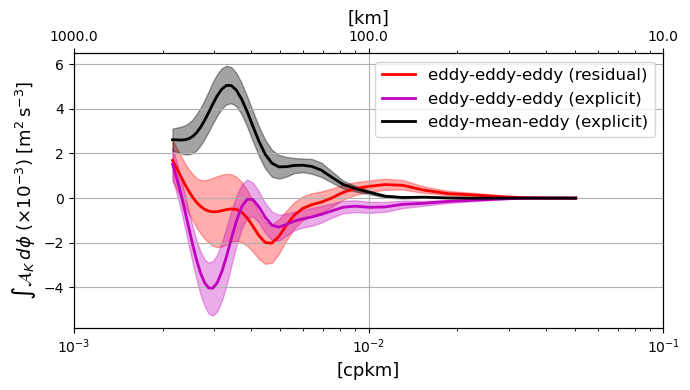

In [14]:
iZ = 1

for reg in range(1):
    ds5 = xr.open_dataset(op.join(spec,'Points/%s/%010d/isoDiags_u-v-adv.zarr' 
                                  % (sreg[reg],iiter))).isel(Z=iZ)

    ns = 1
    
    for ny in range(-ns,ns+1):
        for nx in range(-ns,ns+1):
            if ny == 0 and nx == 0:
                pass
            # elif ny == -1 and nx == -1:
            #     pass
            else:
                if ny < 0:
                    if nx < 0:
                        # try:
                        ds5  = xr.concat([ds5,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u-v-adv_-%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                    np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    else:
                        # try:
                        ds5  = xr.concat([ds5,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u-v-adv_-%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                    np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                else:
                    if nx < 0:
                        # try:
                        ds5  = xr.concat([ds5,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u-v-adv_%02d-%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                    np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb')
                    else:
                        # try:
                        ds5  = xr.concat([ds5,xr.open_zarr(op.join(spec,
                                            'Z0452/Points/%s/%010d/isoDiags_u-v-adv_%02d%02d.zarr' 
                                                               % (sreg[reg],iiter,np.abs(ny),
                                                                    np.abs(nx)))
                                                          ).isel(Z=0)
                                         ], 'nmemb') 
                        
    dks = xr.DataArray(np.abs(np.diff(ds5.scale**-1)).data, dims='scale',
                       coords={'scale':.5*(ds5.scale[1:].data + ds5.scale[:-1].data)}
                      ).interp(scale=ds5.scale, kwargs={"fill_value": "extrapolate"})

    SPu = ds4.iso_SPu
    SPv = ds4.iso_SPv
    SP = (SPu + SPv)
    Ak = (ds0.iso_uA + ds1.iso_vA
          # - MtE
          + SP
         )
    Abk = -(ds5.iso_uUu + ds5.iso_vUv)
    Apk_ex = -(ds5.iso_uuu + ds5.iso_vuv)
    Apk = Ak - Abk

    piwb = (Abk.sum('angle').compute() 
           * np.diff(ds5.angle)[0]*2)
    datas = (piwb, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Pwbres = bootstrap(datas, np.mean, confidence_level=0.95,
                      # n_resamples=100,
                      random_state=rng)
    piwp = (Apk.sum('angle').compute() 
           * np.diff(ds5.angle)[0]*2)
    datas = (piwp, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Pwpres = bootstrap(datas, np.mean, confidence_level=0.95,
                      # n_resamples=100,
                      random_state=rng)
    piw_ = (Apk_ex.sum('angle').compute() 
           * np.diff(ds5.angle)[0]*2)
    datas = (piw_, )  # samples must be in a sequence
    rng = np.random.default_rng()
    Pw_res = bootstrap(datas, np.mean, confidence_level=0.95,
                      # n_resamples=100,
                      random_state=rng)
    
    
    fig, ax = plt.subplots(figsize=(7,4))
    fig.set_tight_layout(True)
    # ax2 = ax.twinx()
    ax3 = ax.twiny()
    
    ax.fill_between((ds0.scale)**-1*1e3, Pwpres.confidence_interval.low*1e3, 
                    Pwpres.confidence_interval.high*1e3, 
                    alpha=.32, color='r')
    ax.fill_between((ds0.scale)**-1*1e3, Pw_res.confidence_interval.low*1e3, 
                    Pw_res.confidence_interval.high*1e3, 
                    alpha=.32, color='m')
    ax.fill_between((ds0.scale)**-1*1e3, Pwbres.confidence_interval.low*1e3, 
                    Pwbres.confidence_interval.high*1e3, 
                    alpha=.36, color='k')
    
#             ax.plot(np.linspace(1e-3,5e-2,10), np.zeros(10), 'k', alpha=.6, lw=1)
    # ax.plot((ds0.scale)**-1*1e3, piw.isel(angle=0,Z=0).mean(['nmemb'])*1e8,
    #         'r', lw=2, label=r"Zonal")
    # ax.plot((ds0.scale)**-1*1e3, piw.isel(angle=len(piw.angle)//2,Z=0).mean(['nmemb'])*1e8,
    #         'c', lw=2, label=r"Meridional")
    # ax.plot((ds0.scale)**-1*1e3, piw.isel(Z=0).mean(['nmemb','angle'])*1e8,
    #         'k', lw=2, label=r"Isotropic")
    ax.plot((ds0.scale)**-1*1e3, piwp.mean(['nmemb'])*1e3,
            'r', lw=2, 
            label=r"eddy-eddy-eddy (residual)")
    ax.plot((ds0.scale)**-1*1e3, piw_.mean(['nmemb'])*1e3,
            'm', lw=2, 
            label=r"eddy-eddy-eddy (explicit)")
    ax.plot((ds0.scale)**-1*1e3, piwb.mean(['nmemb'])*1e3,
            'k', lw=2, 
            label=r"eddy-mean-eddy (explicit)")
    
    ax.set_xscale('log')
#             ax.set_yscale('log')
    # ax2.set_xscale('log')
    ax3.set_xscale('log')
#             ax2.set_yscale('log')
    ax.set_xlim([1e-3,1e-1])

    ax3.set_xlim([1e-3,1e-1])
    ax3.set_xticks([1e-3,1e-2,1e-1])
    ax3.set_xticklabels([1e3,1e2,1e1])
    ax.set_xlabel(r"[cpkm]", fontsize=13)
    ax3.set_xlabel(r"[km]", fontsize=13)
    # ax2.set_ylim([-.3,1])
    # ax2.spines['right'].set_color('b')
    # ax2.yaxis.label.set_color('b')
    # ax2.tick_params(axis='y', colors='b')
    # ax.set_ylabel(r"$\epsilon_K$ ($\times 10^{-8}$) [m$^2$ s$^{-3}$]", fontsize=13)
    ax.set_ylabel(r"$\int\mathcal{A}_K\,d\phi$ ($\times 10^{-3}$) [m$^2\,$s$^{-3}$]", 
                  fontsize=13)
    # ax2.set_ylabel(r"$\hat{\epsilon}$ ($\times 10^{-8}$) [m$^2$ s$^{-3}$]", 
    #                fontsize=13, c='b')
    ax.grid(True)
    if reg == 0:
        # ax.legend(loc='lower left', fontsize=12)
        ax.legend(loc='upper right', fontsize=12)
    # plt.savefig(op.join(spec,'Figs/WKE-specflux_3x3_Region%02d_Z452.pdf' % reg))
    # plt.savefig(op.join(savedir,
    #                     'Figs/WvsF_KE-specflux_reenvisioned_Region%02d_Z452.pdf' 
    #                     % reg))
    plt.show()